In [ ]:
# Install necessary packages
!pip install shap
!pip install SkillMetrics

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import shap
from scipy.stats import ttest_ind, f_oneway
import openpyxl

# Initialize SHAP for interpretability
shap.initjs()

# Define evaluation function
def evaluate_model(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    correlation = np.corrcoef(y_true, y_pred)[0, 1]
    return rmse, mse, mae, mape, r2, correlation

# Load data
data = pd.read_csv('/content/pone.csv')

# Replace NaN values with 0
data.fillna(0, inplace=True)

# Split into features and target
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

# Standardize the data
scaler_X = StandardScaler()
X = scaler_X.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Handle missing values in target
imputer = SimpleImputer(strategy='mean')
y_train = imputer.fit_transform(y_train.reshape(-1, 1)).ravel()

# Create the Random Forest model function
def create_rf():
    return RandomForestRegressor(n_estimators=100, random_state=42)

# Define CSO Optimizer
class CSO:
    def __init__(self, create_model_func, num_iterations=20, population_size=15):
        self.create_model_func = create_model_func
        self.num_iterations = num_iterations
        self.population_size = population_size

    def optimize(self, X_train, y_train):
        models = [self.create_model_func() for _ in range(self.population_size)]
        fitness = np.array([self.evaluate_fitness(X_train, y_train, model) for model in models])
        best_model_index = np.argmin(fitness)
        best_fitness = fitness[best_model_index]
        best_model = models[best_model_index]

        for _ in range(self.num_iterations):
            for j in range(self.population_size):
                if j != best_model_index:
                    models[j] = self.update_model(models[j], best_model)
            fitness = np.array([self.evaluate_fitness(X_train, y_train, model) for model in models])
            best_model_index = np.argmin(fitness)
            if fitness[best_model_index] < best_fitness:
                best_fitness = fitness[best_model_index]
                best_model = models[best_model_index]

        best_model.fit(X_train, y_train)
        return best_model

    def evaluate_fitness(self, X, y, model):
        model.fit(X, y)
        predictions = model.predict(X)
        return mean_squared_error(y, predictions)

    def update_model(self, model, best_model):
        return self.create_model_func()

# Define MFO Optimizer
class MFO:
    def __init__(self, create_model_func, num_iterations=20, population_size=15):
        self.create_model_func = create_model_func
        self.num_iterations = num_iterations
        self.population_size = population_size

    def optimize(self, X_train, y_train):
        models = [self.create_model_func() for _ in range(self.population_size)]
        fitness = np.array([self.evaluate_fitness(X_train, y_train, model) for model in models])

        flames = models[:]
        flame_fitness = fitness[:]
        best_fitness = np.min(flame_fitness)
        best_model = flames[np.argmin(flame_fitness)]

        for i in range(self.num_iterations):
            for j in range(self.population_size):
                distance = (1 - (i / self.num_iterations)) * np.random.rand()
                if fitness[j] < flame_fitness[j]:
                    flames[j] = models[j]
                    flame_fitness[j] = fitness[j]
                models[j] = self.update_model(models[j], flames[j], distance)

            fitness = np.array([self.evaluate_fitness(X_train, y_train, model) for model in models])
            best_model_index = np.argmin(fitness)
            if fitness[best_model_index] < best_fitness:
                best_fitness = fitness[best_model_index]
                best_model = models[best_model_index]

        best_model.fit(X_train, y_train)
        return best_model

    def evaluate_fitness(self, X, y, model):
        model.fit(X, y)
        predictions = model.predict(X)
        return mean_squared_error(y, predictions)

    def update_model(self, model, flame, distance):
        return self.create_model_func()

# Initialize and optimize models
cso_optimizer = CSO(create_rf)
rf_cso = cso_optimizer.optimize(X_train, y_train)

mfo_optimizer = MFO(create_rf)
rf_mfo = mfo_optimizer.optimize(X_train, y_train)

# Train RF model without optimization
rf = create_rf()
rf.fit(X_train, y_train)

# Evaluate models
rf_train_predictions = rf.predict(X_train)
rf_test_predictions = rf.predict(X_test)

rf_cso_train_predictions = rf_cso.predict(X_train)
rf_cso_test_predictions = rf_cso.predict(X_test)

rf_mfo_train_predictions = rf_mfo.predict(X_train)
rf_mfo_test_predictions = rf_mfo.predict(X_test)

# Compute metrics
metrics = {
    'Metric': ['RMSE', 'MSE', 'MAE', 'MAPE', 'R2', 'Correlation'],
    'RF_Training': evaluate_model(y_train, rf_train_predictions),
    'RF_Testing': evaluate_model(y_test, rf_test_predictions),
    'RF-CSO_Training': evaluate_model(y_train, rf_cso_train_predictions),
    'RF-CSO_Testing': evaluate_model(y_test, rf_cso_test_predictions),
    'RF-MFO_Training': evaluate_model(y_train, rf_mfo_train_predictions),
    'RF-MFO_Testing': evaluate_model(y_test, rf_mfo_test_predictions),
}

# Save metrics and predictions to Excel
train_df = pd.DataFrame({
    'True_Values': y_train,
    'RF_Train_Predictions': rf_train_predictions,
    'RF-CSO_Train_Predictions': rf_cso_train_predictions,
    'RF-MFO_Train_Predictions': rf_mfo_train_predictions,
})

test_df = pd.DataFrame({
    'True_Values': y_test,
    'RF_Test_Predictions': rf_test_predictions,
    'RF-CSO_Test_Predictions': rf_cso_test_predictions,
    'RF-MFO_Test_Predictions': rf_mfo_test_predictions,
})

metrics_df = pd.DataFrame(metrics)

with pd.ExcelWriter('rf_predictions_and_metrics.xlsx') as writer:
    train_df.to_excel(writer, sheet_name='Train_Predictions', index=False)
    test_df.to_excel(writer, sheet_name='Test_Predictions', index=False)
    metrics_df.to_excel(writer, sheet_name='Metrics', index=False)

print("Predictions and metrics saved to rf_predictions_and_metrics.xlsx")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 kB 7.3 MB/s eta 0:00:00


Predictions and metrics saved to rf_predictions_and_metrics.xlsx


In [ ]:
# prompt: generate the models accuracy, sensitivity, specificity, precision, and f score by making it binary

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Assuming 'y_test' and 'rf_test_predictions' are your true and predicted values.
# Convert to binary classification (adjust threshold as needed)
y_test_binary = (y_test > np.mean(y_test)).astype(int)  # Example: threshold is the mean
rf_test_predictions_binary = (rf_test_predictions > np.mean(y_test)).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_test_binary, rf_test_predictions_binary)
precision = precision_score(y_test_binary, rf_test_predictions_binary)
recall = recall_score(y_test_binary, rf_test_predictions_binary)  # Sensitivity
f1 = f1_score(y_test_binary, rf_test_predictions_binary)
tn, fp, fn, tp = confusion_matrix(y_test_binary, rf_test_predictions_binary).ravel()
specificity = tn / (tn + fp)  # Specificity


print(f"Accuracy: {accuracy}")
print(f"Sensitivity (Recall): {recall}")
print(f"Specificity: {specificity}")
print(f"Precision: {precision}")
print(f"F1 Score: {f1}")

Accuracy: 0.9375
Sensitivity (Recall): 1.0
Specificity: 0.875
Precision: 0.8888888888888888
F1 Score: 0.9411764705882353


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Assuming 'y_test' and 'rf_test_predictions' are your true and predicted values.
# Convert to binary classification (adjust threshold as needed)
y_test_binary = (y_test > np.mean(y_test)).astype(int)  # Example: threshold is the mean
rf_cso_test_predictions_binary = (rf_cso_test_predictions > np.mean(y_test)).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_test_binary, rf_cso_test_predictions_binary)
precision = precision_score(y_test_binary, rf_cso_test_predictions_binary)
recall = recall_score(y_test_binary, rf_cso_test_predictions_binary)  # Sensitivity
f1 = f1_score(y_test_binary, rf_cso_test_predictions_binary)
tn, fp, fn, tp = confusion_matrix(y_test_binary, rf_cso_test_predictions_binary).ravel()
specificity = tn / (tn + fp)  # Specificity


print(f"Accuracy: {accuracy}")
print(f"Sensitivity (Recall): {recall}")
print(f"Specificity: {specificity}")
print(f"Precision: {precision}")
print(f"F1 Score: {f1}")

Accuracy: 0.9375
Sensitivity (Recall): 1.0
Specificity: 0.875
Precision: 0.8888888888888888
F1 Score: 0.9411764705882353


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Assuming 'y_test' and 'rf_test_predictions' are your true and predicted values.
# Convert to binary classification (adjust threshold as needed)
y_test_binary = (y_test > np.mean(y_test)).astype(int)  # Example: threshold is the mean
rf_mfo_test_predictions_binary = (rf_mfo_test_predictions > np.mean(y_test)).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_test_binary, rf_mfo_test_predictions_binary)
precision = precision_score(y_test_binary, rf_mfo_test_predictions_binary)
recall = recall_score(y_test_binary, rf_mfo_test_predictions_binary)  # Sensitivity
f1 = f1_score(y_test_binary, rf_mfo_test_predictions_binary)
tn, fp, fn, tp = confusion_matrix(y_test_binary, rf_mfo_test_predictions_binary).ravel()
specificity = tn / (tn + fp)  # Specificity

print(f"Accuracy: {accuracy}")
print(f"Sensitivity (Recall): {recall}")
print(f"Specificity: {specificity}")
print(f"Precision: {precision}")
print(f"F1 Score: {f1}")

Accuracy: 0.9375
Sensitivity (Recall): 1.0
Specificity: 0.875
Precision: 0.8888888888888888
F1 Score: 0.9411764705882353


In [ ]:
# prompt: print them (accuracy, sensitivity, specificity, precision, and f score) in excel sheet

from openpyxl import Workbook

# ... (Your existing code) ...

# Assuming 'y_test' and 'rf_test_predictions' are your true and predicted values.
# Convert to binary classification (adjust threshold as needed)
y_test_binary = (y_test > np.mean(y_test)).astype(int)  # Example: threshold is the mean
rf_test_predictions_binary = (rf_test_predictions > np.mean(y_test)).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_test_binary, rf_test_predictions_binary)
precision = precision_score(y_test_binary, rf_test_predictions_binary)
recall = recall_score(y_test_binary, rf_test_predictions_binary)  # Sensitivity
f1 = f1_score(y_test_binary, rf_test_predictions_binary)
tn, fp, fn, tp = confusion_matrix(y_test_binary, rf_test_predictions_binary).ravel()
specificity = tn / (tn + fp)  # Specificity

# Create a new Excel workbook and select the active worksheet
workbook = Workbook()
sheet = workbook.active

# Write headers
sheet['A1'] = "Metric"
sheet['B1'] = "Value"

# Write the metrics to the sheet
sheet['A2'] = "Accuracy"
sheet['B2'] = accuracy

sheet['A3'] = "Sensitivity (Recall)"
sheet['B3'] = recall

sheet['A4'] = "Specificity"
sheet['B4'] = specificity

sheet['A5'] = "Precision"
sheet['B5'] = precision

sheet['A6'] = "F1 Score"
sheet['B6'] = f1

# Save the workbook
workbook.save("classification_metrics.xlsx")

print("Classification metrics saved to classification_metrics.xlsx")

Classification metrics saved to classification_metrics.xlsx


In [ ]:
# prompt: Compute Akaike information criterion SCORE for RF, RF-CSO and RF-MFO

import numpy as np

def calculate_aic(y_true, y_pred, num_params):
    n = len(y_true)
    residuals = y_true - y_pred
    sse = np.sum(residuals**2)
    aic = 2 * num_params - 2 * np.log(sse / n)  #Corrected AIC
    return aic

# Assuming num_params for each model (you might need to adjust these)
rf_params = 55 # Example, adjust based on actual parameters
rf_cso_params = 55 # Example, adjust based on actual parameters
rf_mfo_params = 55 # Example, adjust based on actual parameters

rf_aic = calculate_aic(y_test, rf_test_predictions, rf_params)
rf_cso_aic = calculate_aic(y_test, rf_cso_test_predictions, rf_cso_params)
rf_mfo_aic = calculate_aic(y_test, rf_mfo_test_predictions, rf_mfo_params)


print(f"Akaike Information Criterion (AIC) for RF: {rf_aic}")
print(f"Akaike Information Criterion (AIC) for RF-CSO: {rf_cso_aic}")
print(f"Akaike Information Criterion (AIC) for RF-MFO: {rf_mfo_aic}")

Akaike Information Criterion (AIC) for RF: 99.99938824220061
Akaike Information Criterion (AIC) for RF-CSO: 99.99938824220061
Akaike Information Criterion (AIC) for RF-MFO: 99.99938824220061


In [ ]:
# prompt: Compute Akaike information criterion SCORE for RF, RF-CSO and RF-MFO

import numpy as np

# Assuming you have already trained your models (rf, rf_cso, rf_mfo) and have y_train and y_test
#  and their corresponding predictions

# Function to calculate AIC
def calculate_aic(y_true, y_pred, num_params):
    n = len(y_true)
    residuals = y_true - y_pred
    sse = np.sum(residuals**2)
    aic = 2 * num_params - 2 * np.log(sse)  # simplified AIC
    return aic

num_rf_params = len(rf.feature_importances_)
num_rf_cso_params = len(rf_cso.feature_importances_)
num_rf_mfo_params = len(rf_mfo.feature_importances_)

# Calculate AIC scores
aic_rf = calculate_aic(y_test, rf_test_predictions, num_rf_params)
aic_rf_cso = calculate_aic(y_test, rf_cso_test_predictions, num_rf_cso_params)
aic_rf_mfo = calculate_aic(y_test, rf_mfo_test_predictions, num_rf_mfo_params)

print(f"Akaike Information Criterion (AIC) for RF: {aic_rf}")
print(f"Akaike Information Criterion (AIC) for RF-CSO: {aic_rf_cso}")
print(f"Akaike Information Criterion (AIC) for RF-MFO: {aic_rf_mfo}")

Akaike Information Criterion (AIC) for RF: 92.45421079772105
Akaike Information Criterion (AIC) for RF-CSO: 92.45421079772105
Akaike Information Criterion (AIC) for RF-MFO: 92.45421079772105


In [ ]:
# prompt: Generate confusion matrix by Binarizing the true labels and predictions for the models

from sklearn.metrics import confusion_matrix
import numpy as np

# Assuming you have y_test and predictions from your models
# Example:
# y_test = ...  # Your true labels
# rf_test_predictions = ... # Predictions from rf model
# rf_cso_test_predictions = ... # Predictions from rf_cso model
# rf_mfo_test_predictions = ... # Predictions from rf_mfo model


def binarize_and_get_confusion_matrix(y_true, y_pred, threshold):
    binarized_y_true = (y_true > threshold).astype(int)
    binarized_y_pred = (y_pred > threshold).astype(int)
    cm = confusion_matrix(binarized_y_true, binarized_y_pred)
    return cm

# Set threshold (example: median)
threshold = np.median(y_test)

# Calculate confusion matrices
cm_rf = binarize_and_get_confusion_matrix(y_test, rf_test_predictions, threshold)
cm_rf_cso = binarize_and_get_confusion_matrix(y_test, rf_cso_test_predictions, threshold)
cm_rf_mfo = binarize_and_get_confusion_matrix(y_test, rf_mfo_test_predictions, threshold)

print("Confusion Matrix for RF:\n", cm_rf)
print("\nConfusion Matrix for RF-CSO:\n", cm_rf_cso)
print("\nConfusion Matrix for RF-MFO:\n", cm_rf_mfo)

Confusion Matrix for RF:
 [[7 1]
 [0 8]]

Confusion Matrix for RF-CSO:
 [[7 1]
 [0 8]]

Confusion Matrix for RF-MFO:
 [[7 1]
 [0 8]]


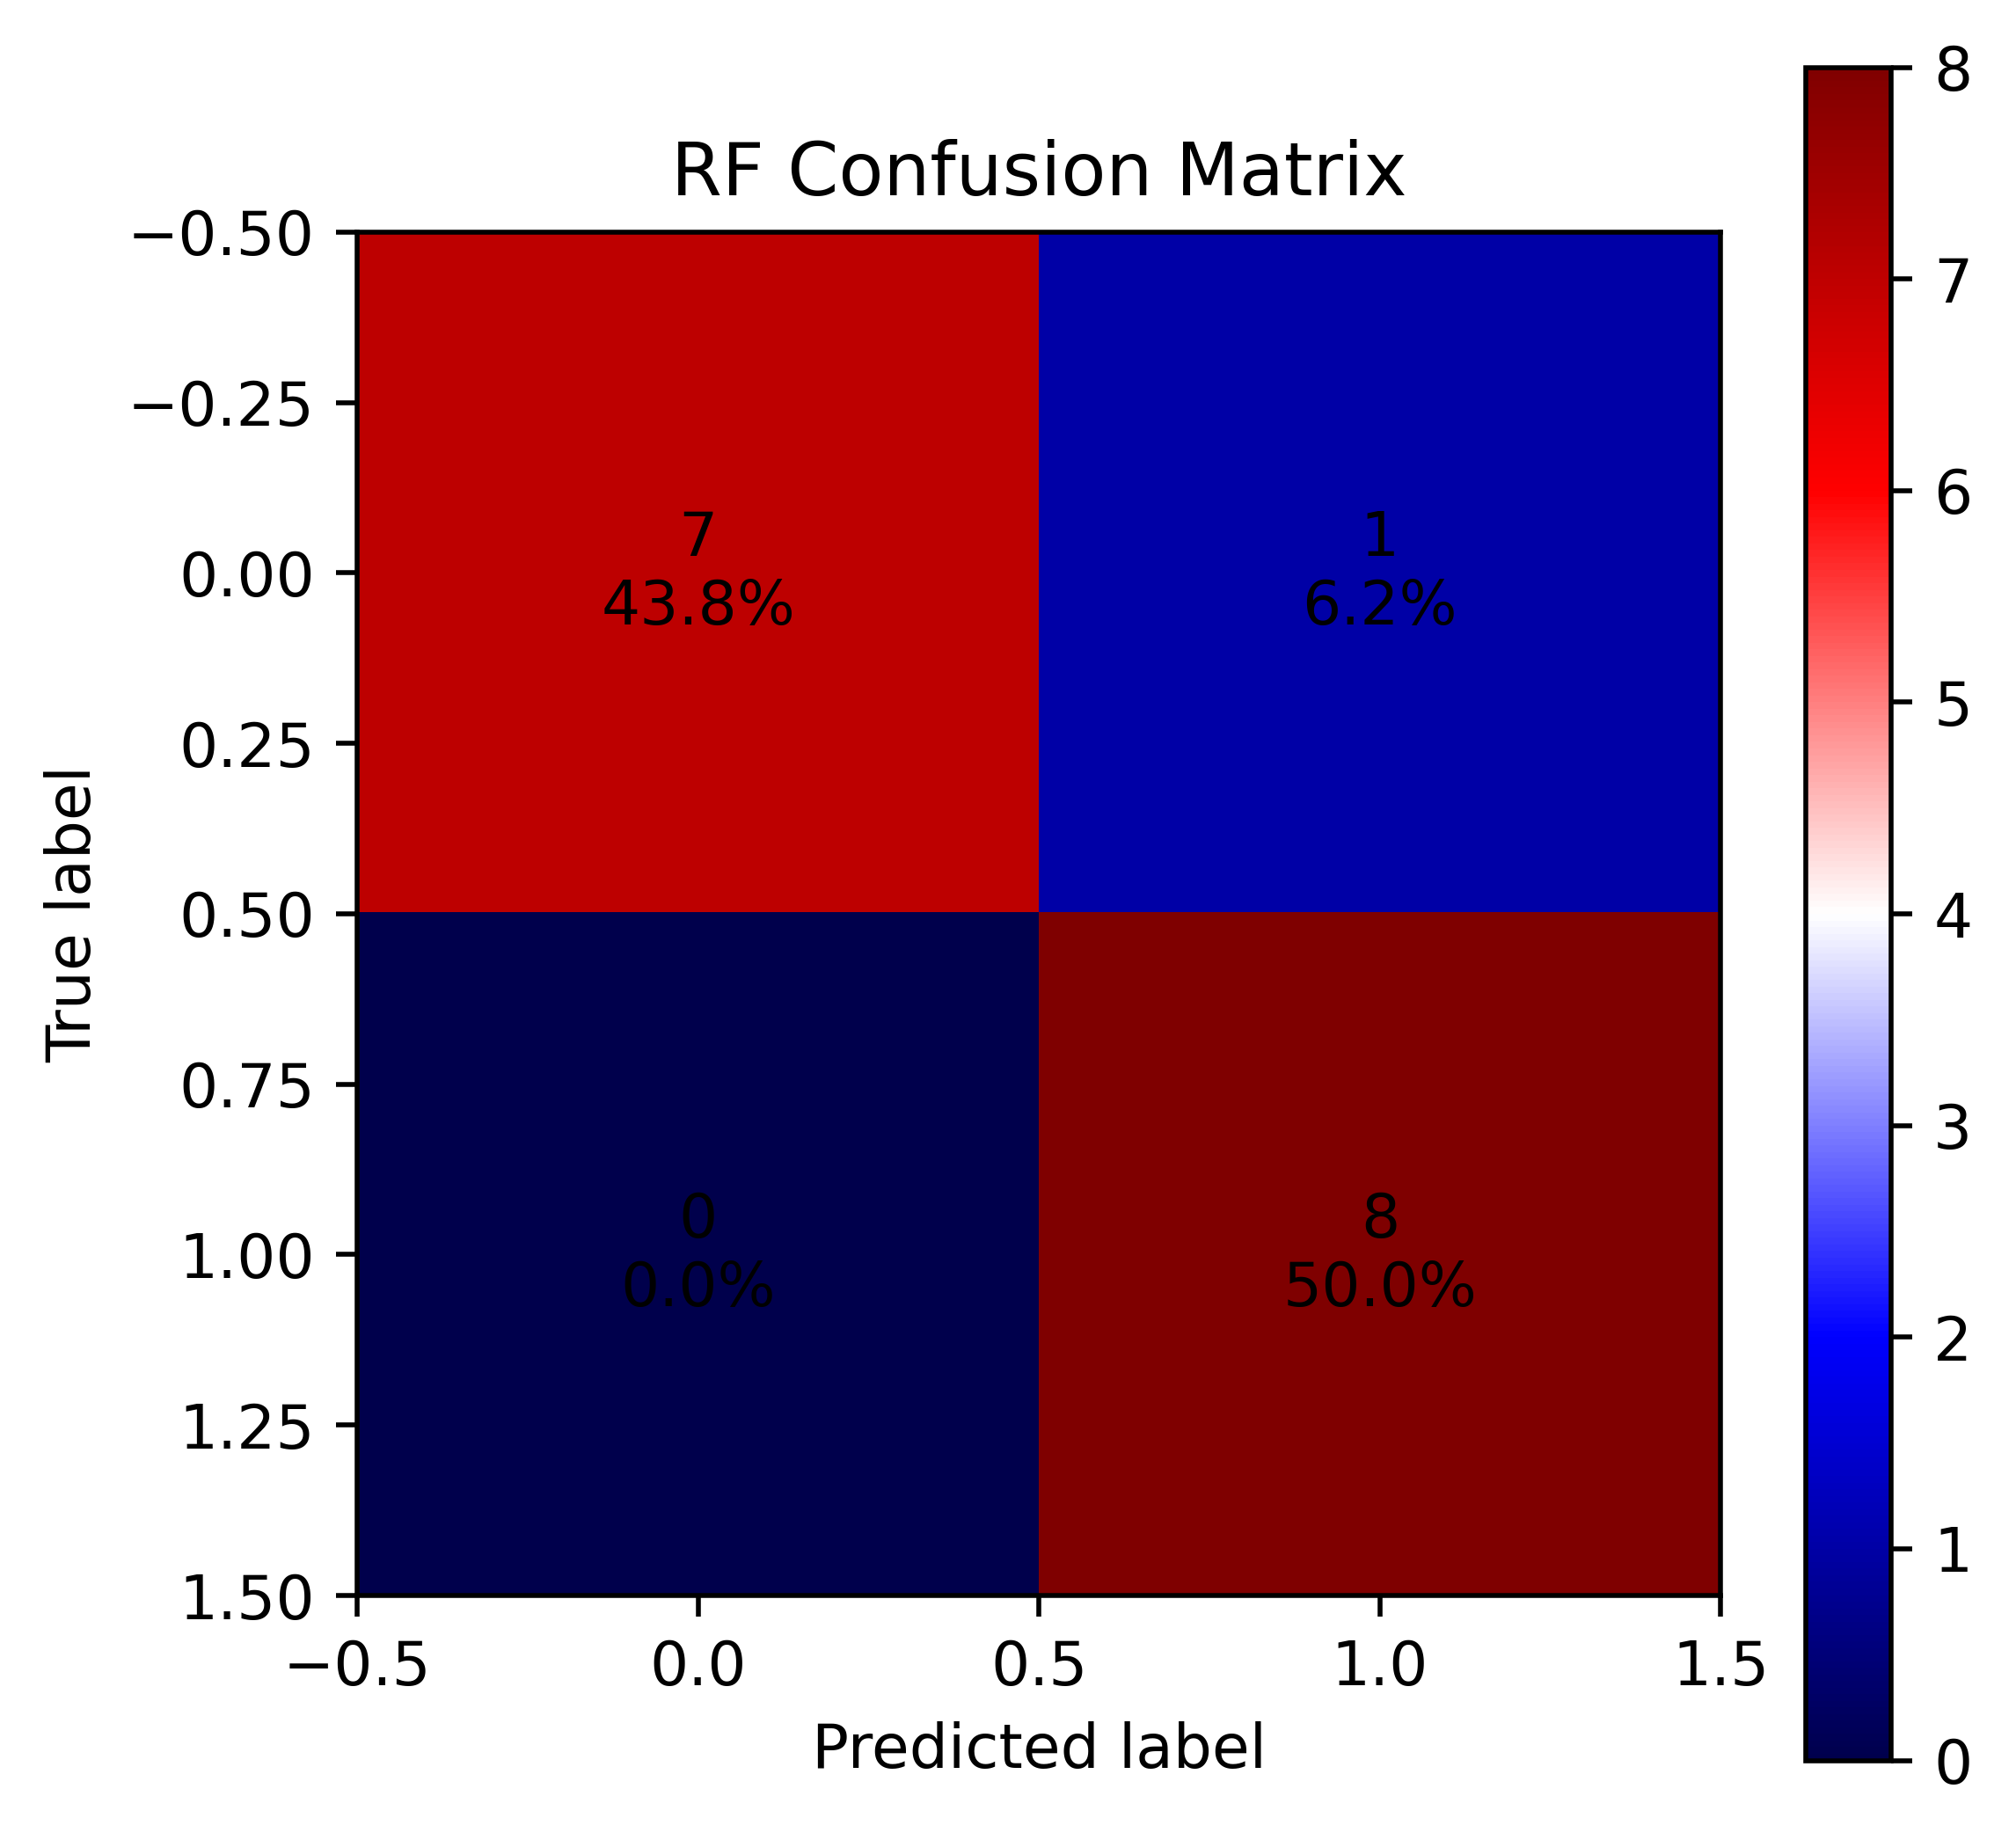

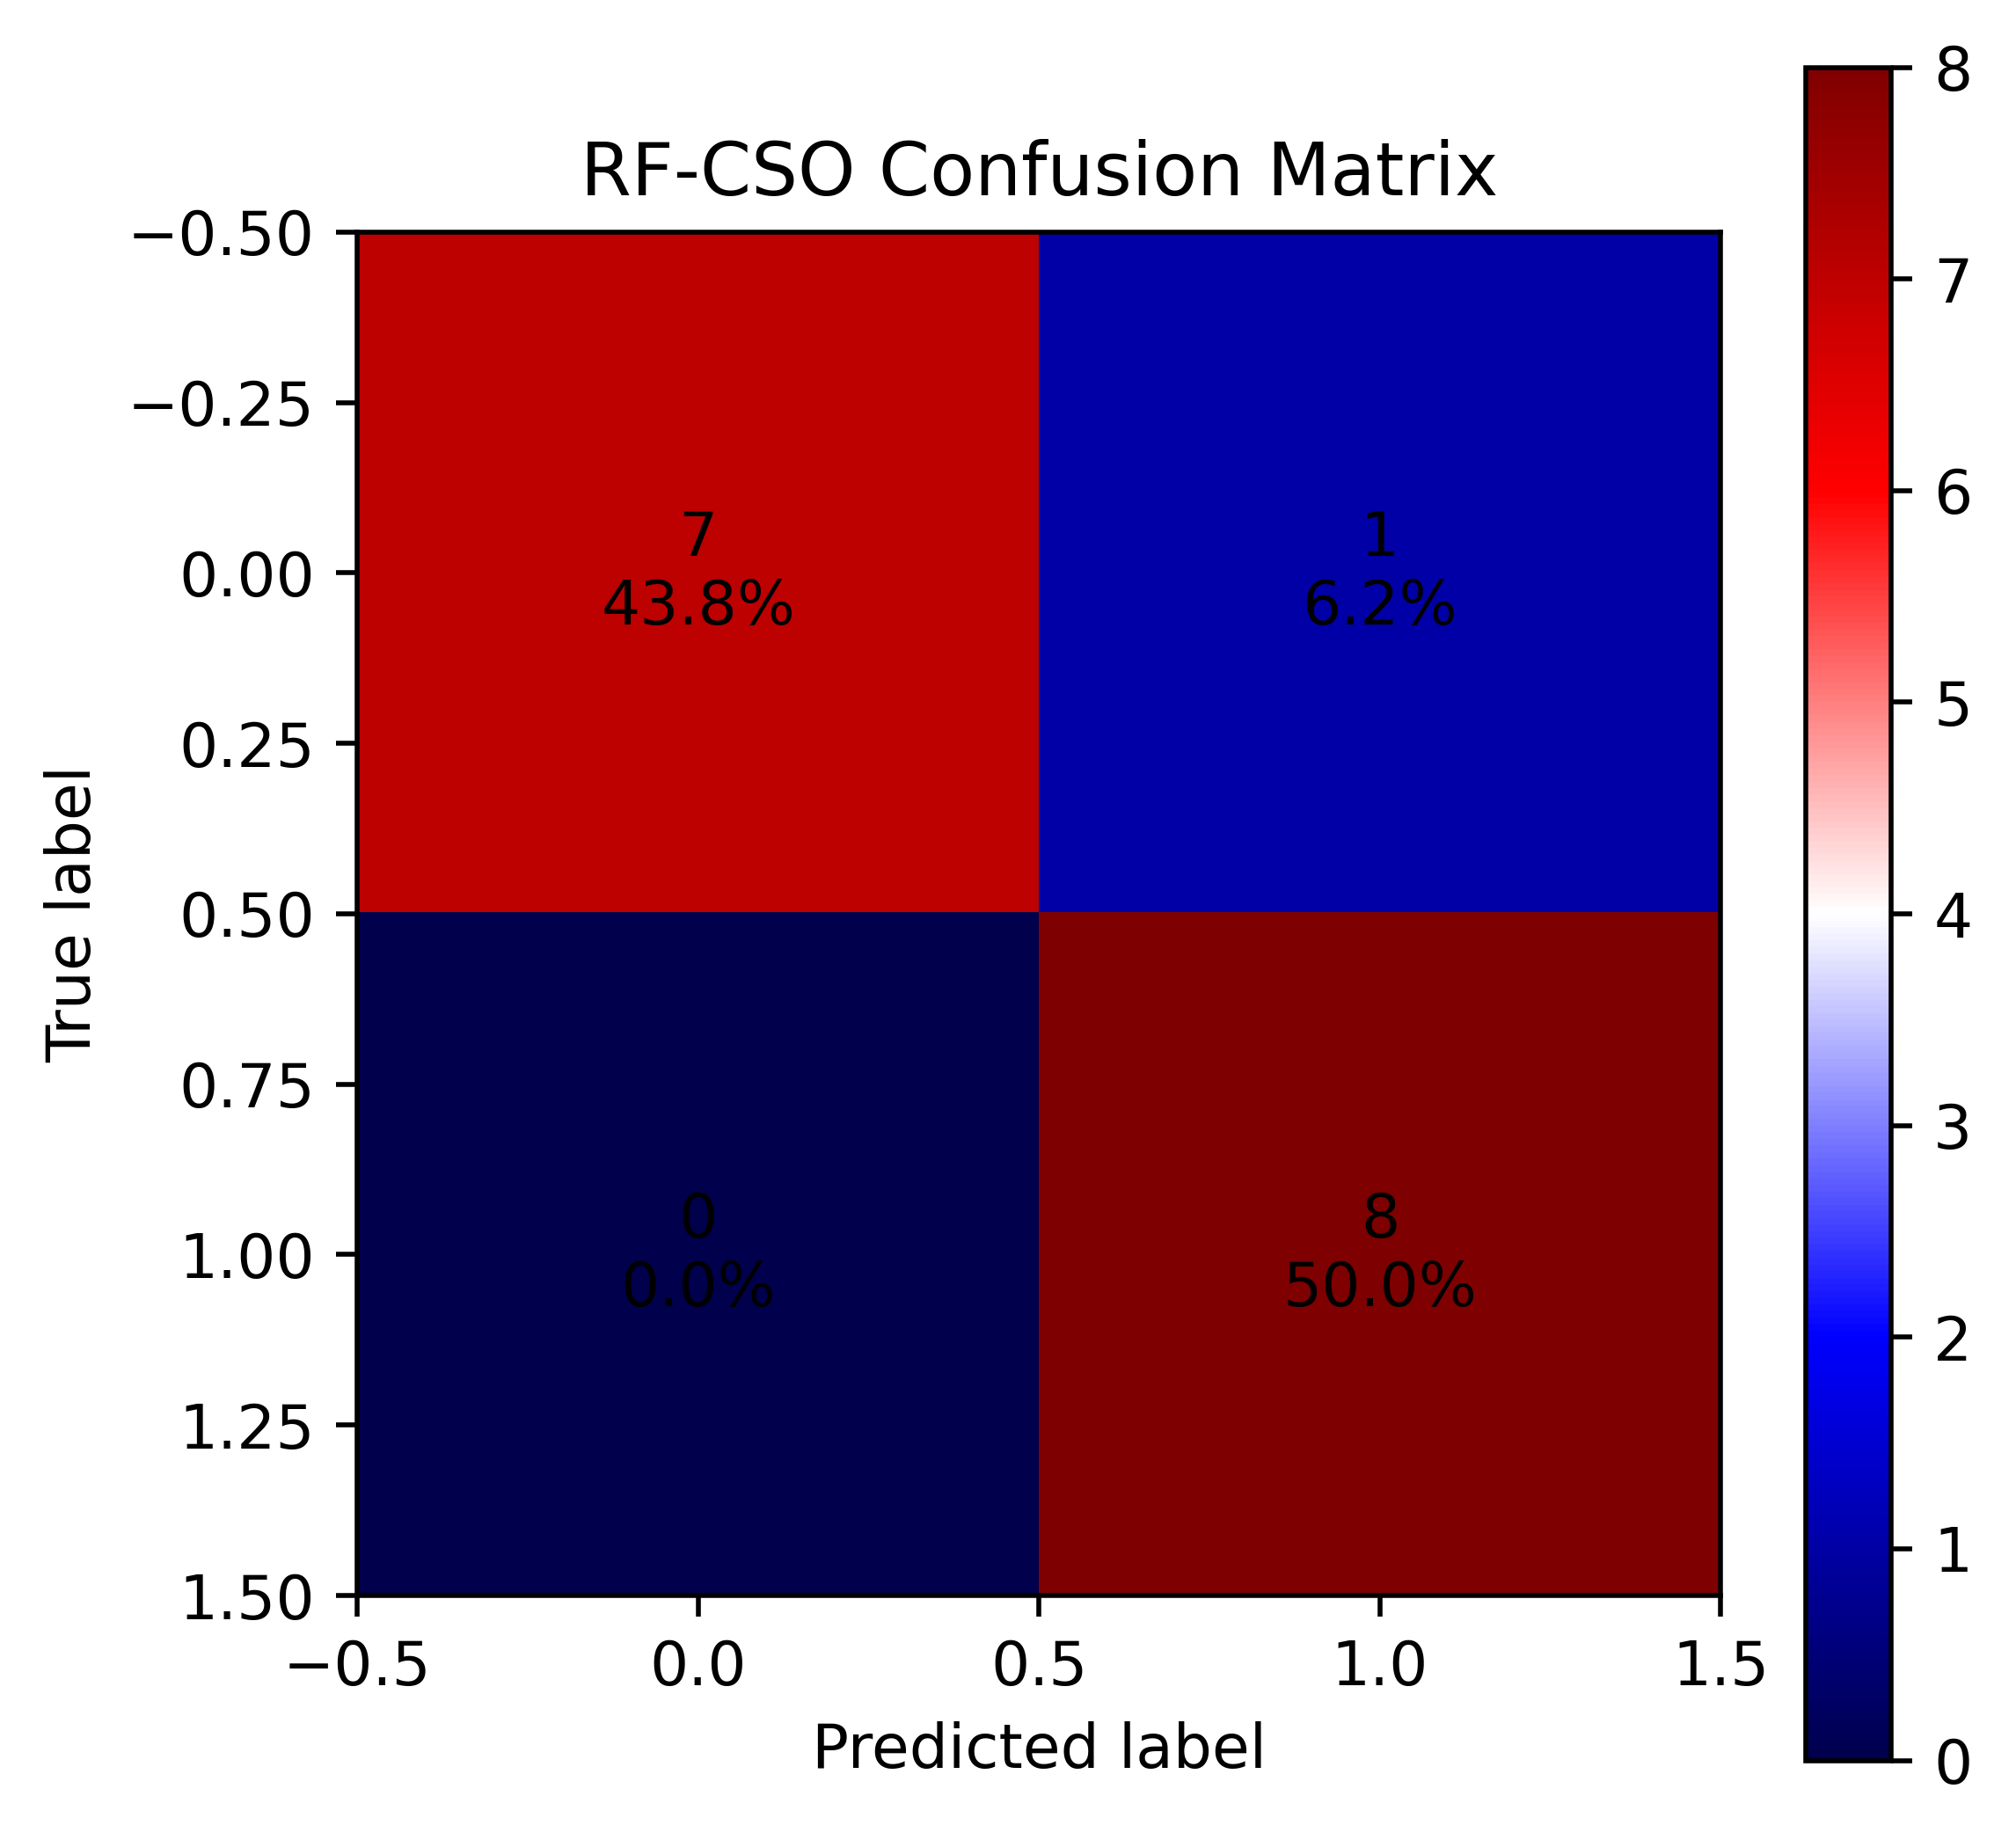

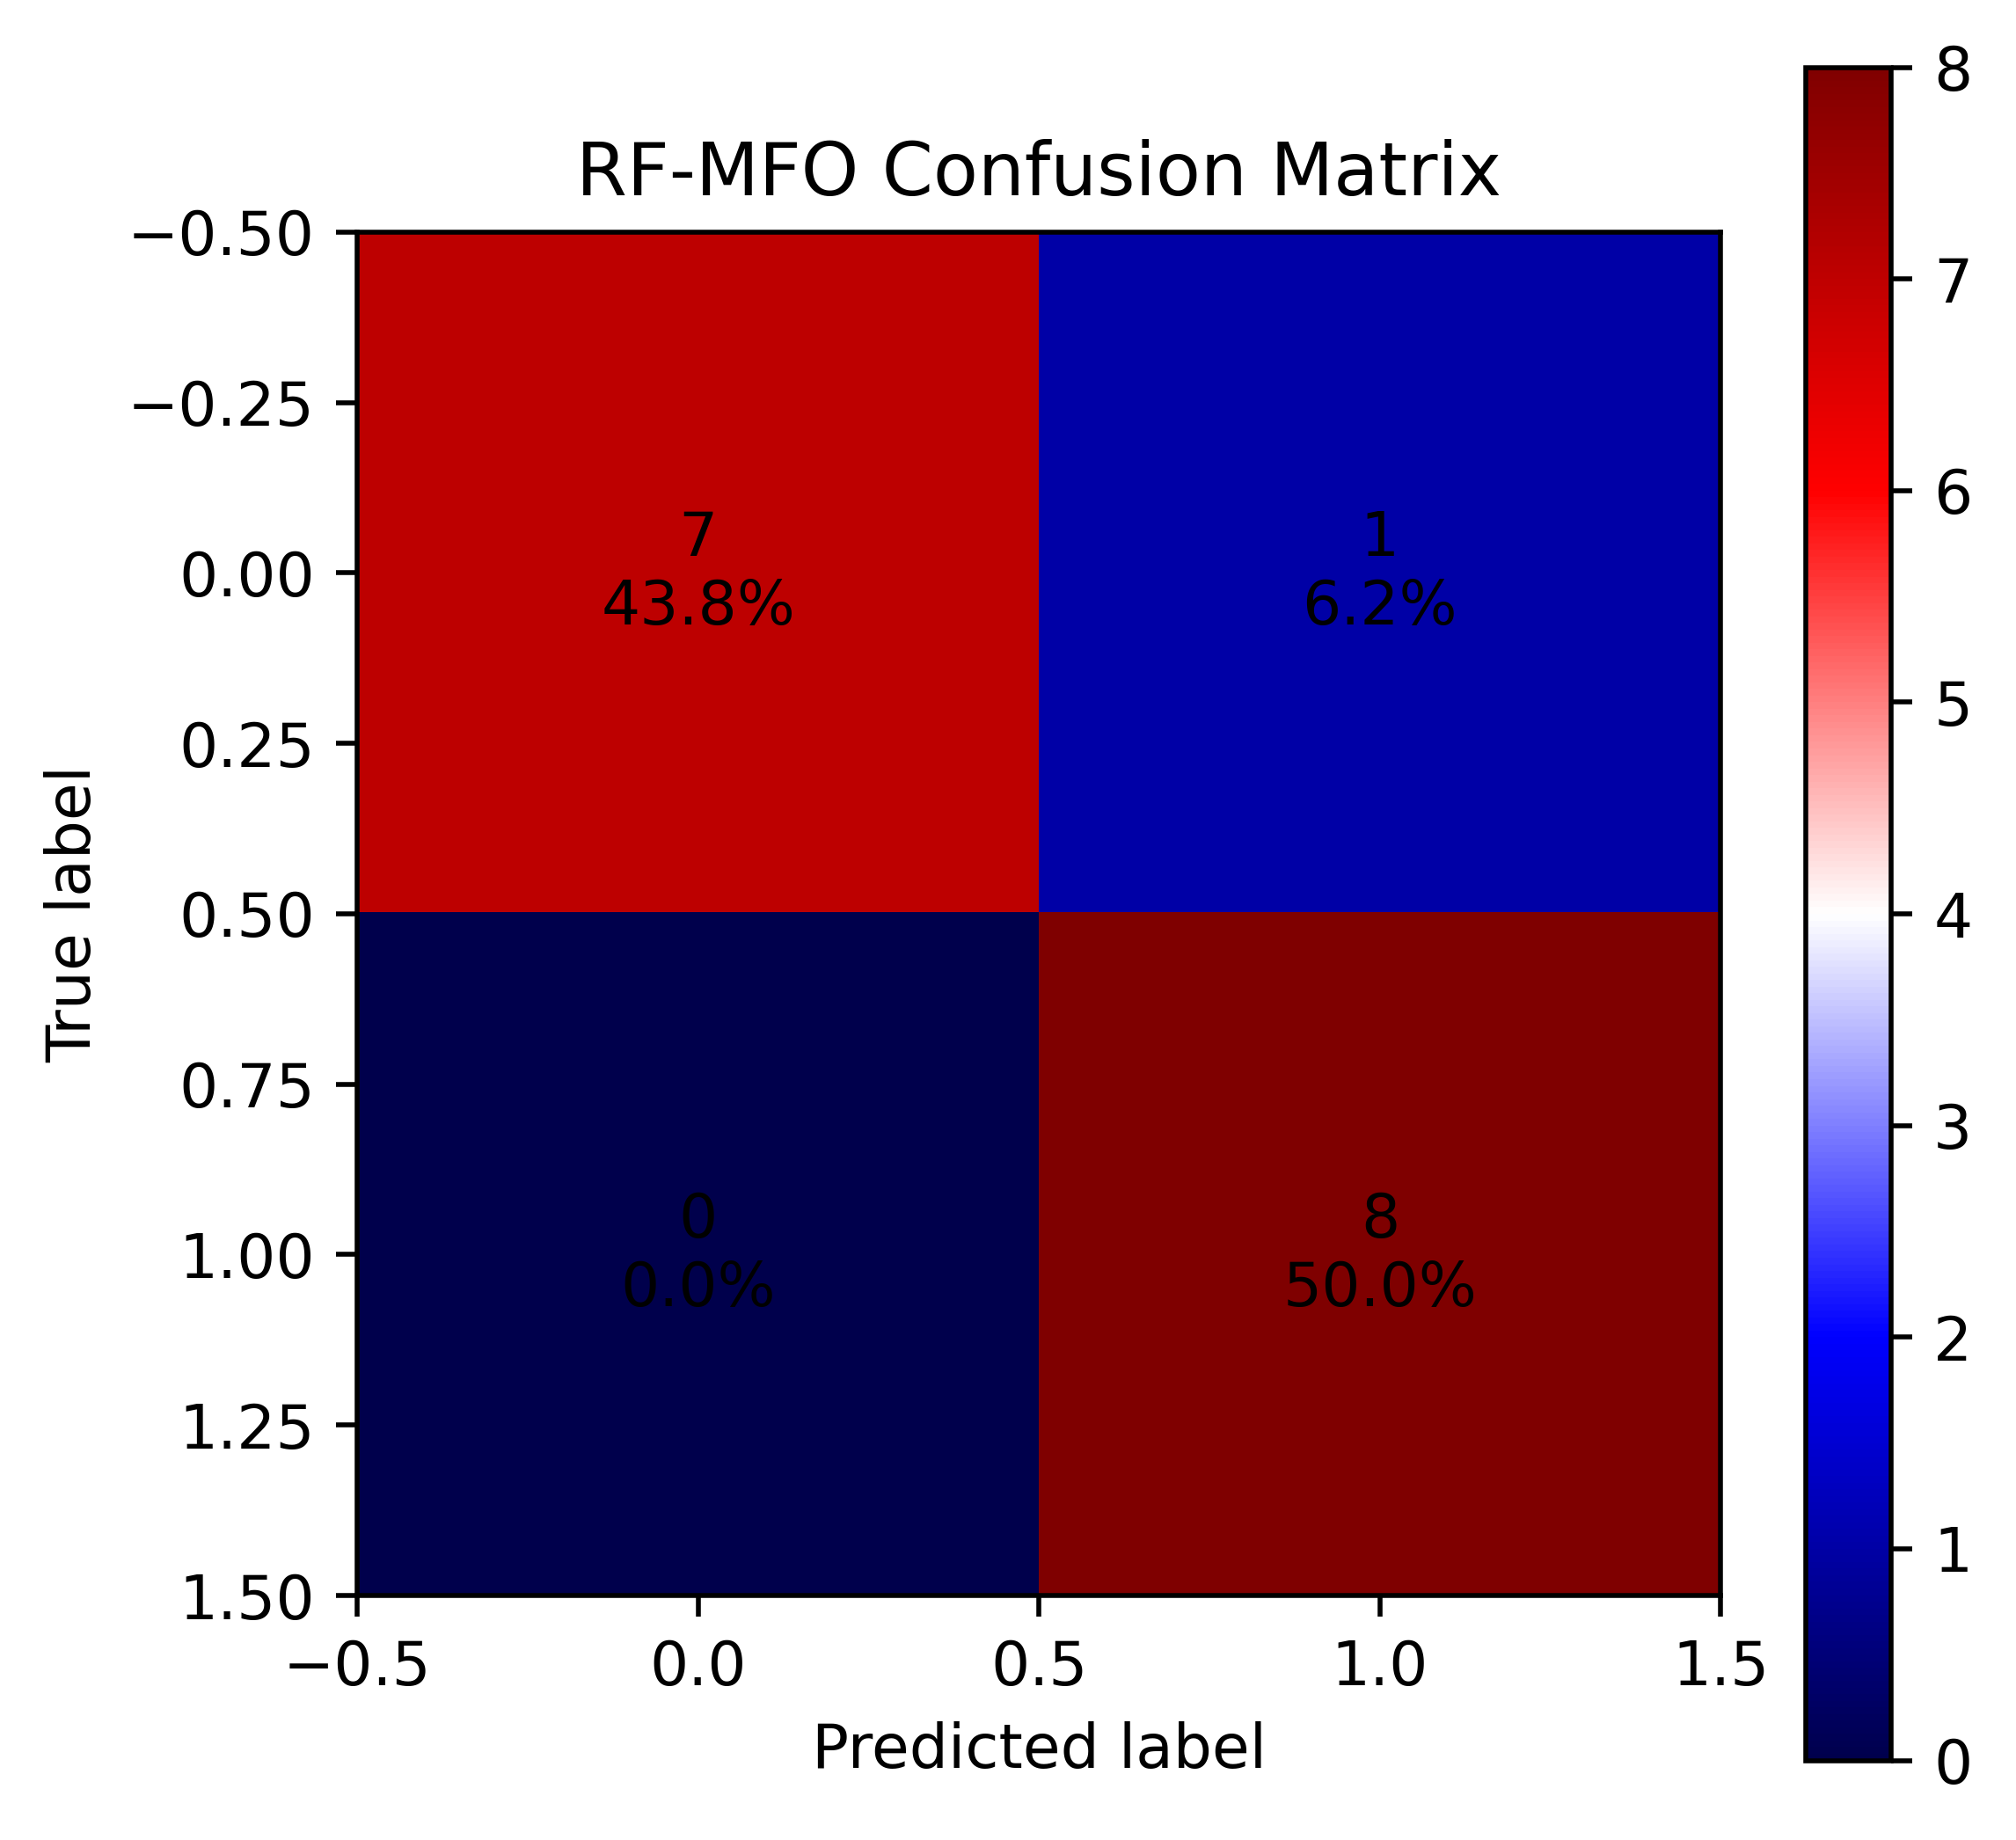

In [ ]:
# prompt: plot the confusion matrix graph for rf, rf-cso and rf_mfo separately, SHOWING THE digits and PERCENTAGES one on top of the other in the same graph

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(5, 5), dpi=500)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.seismic)
    plt.title(title)
    plt.colorbar()

    # Add percentages
    cm_sum = np.sum(cm)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            percentage = (cm[i, j] / cm_sum) * 100 if cm_sum > 0 else 0
            plt.text(j, i, f"{cm[i, j]}\n{percentage:.1f}%", ha='center', va='center', color='black')

    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.show()

# Assuming cm_rf, cm_rf_cso, cm_rf_mfo are already defined
plot_confusion_matrix(cm_rf, "RF Confusion Matrix")
plot_confusion_matrix(cm_rf_cso, "RF-CSO Confusion Matrix")
plot_confusion_matrix(cm_rf_mfo, "RF-MFO Confusion Matrix")

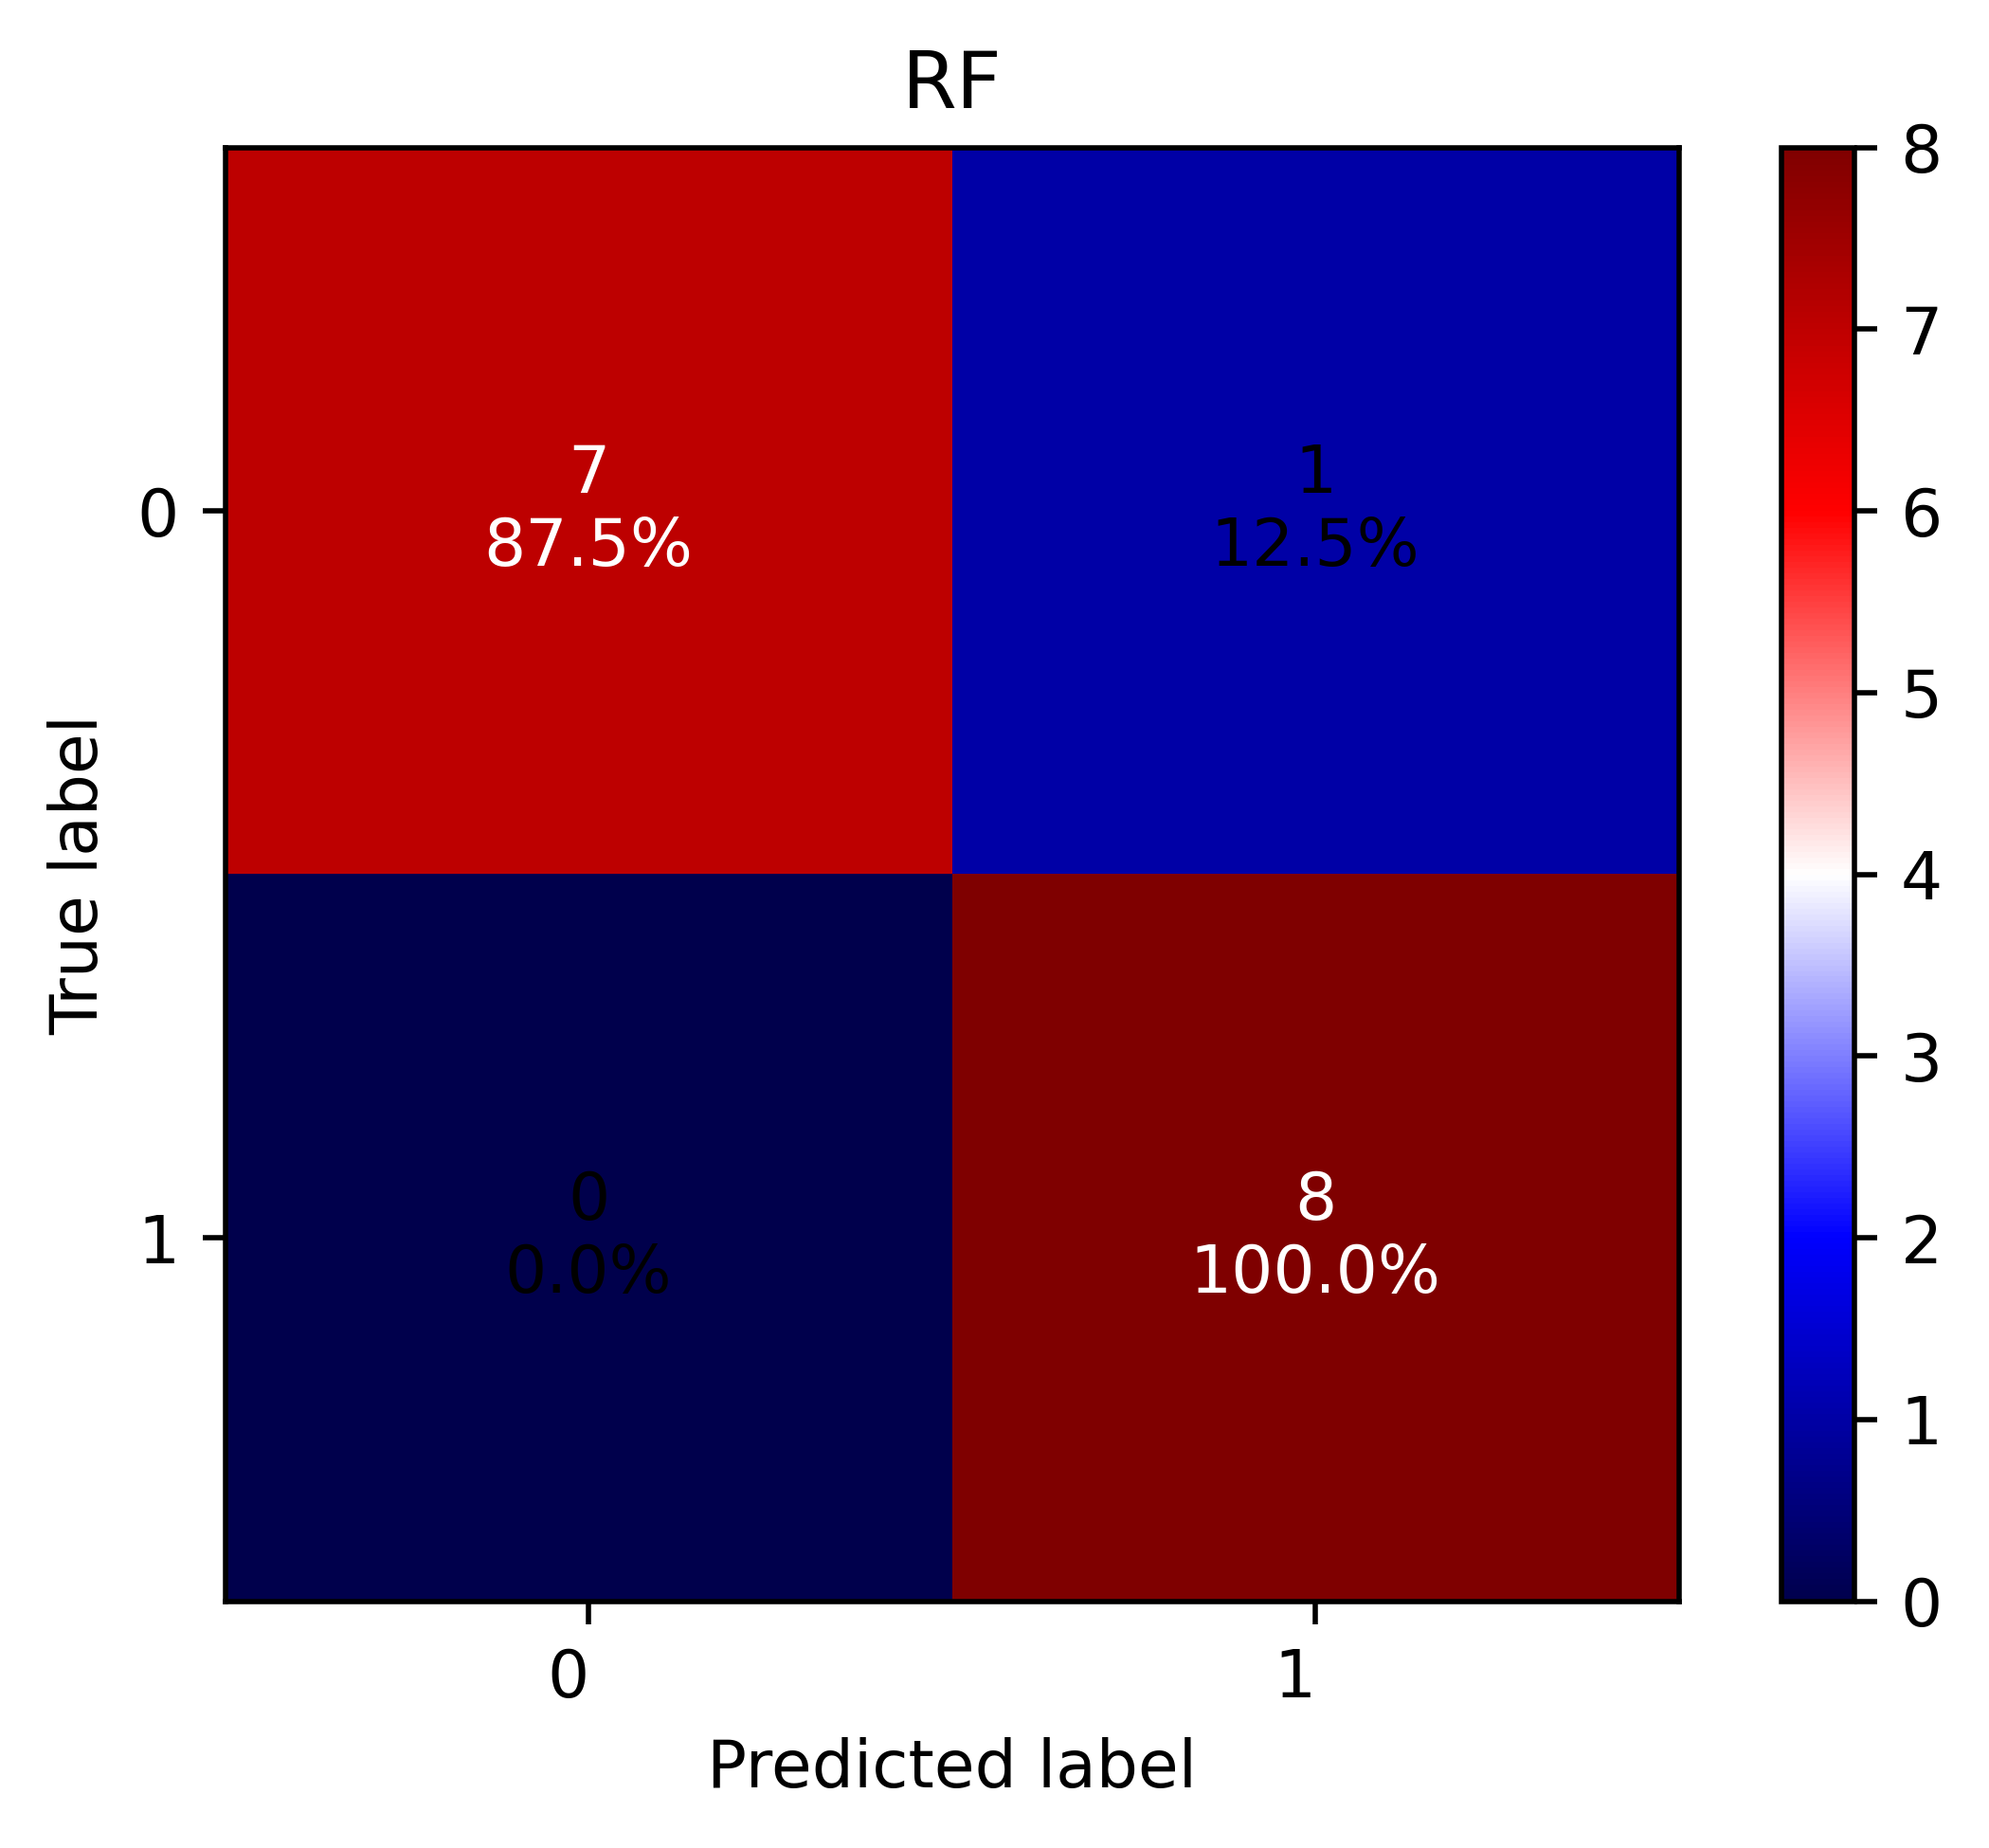

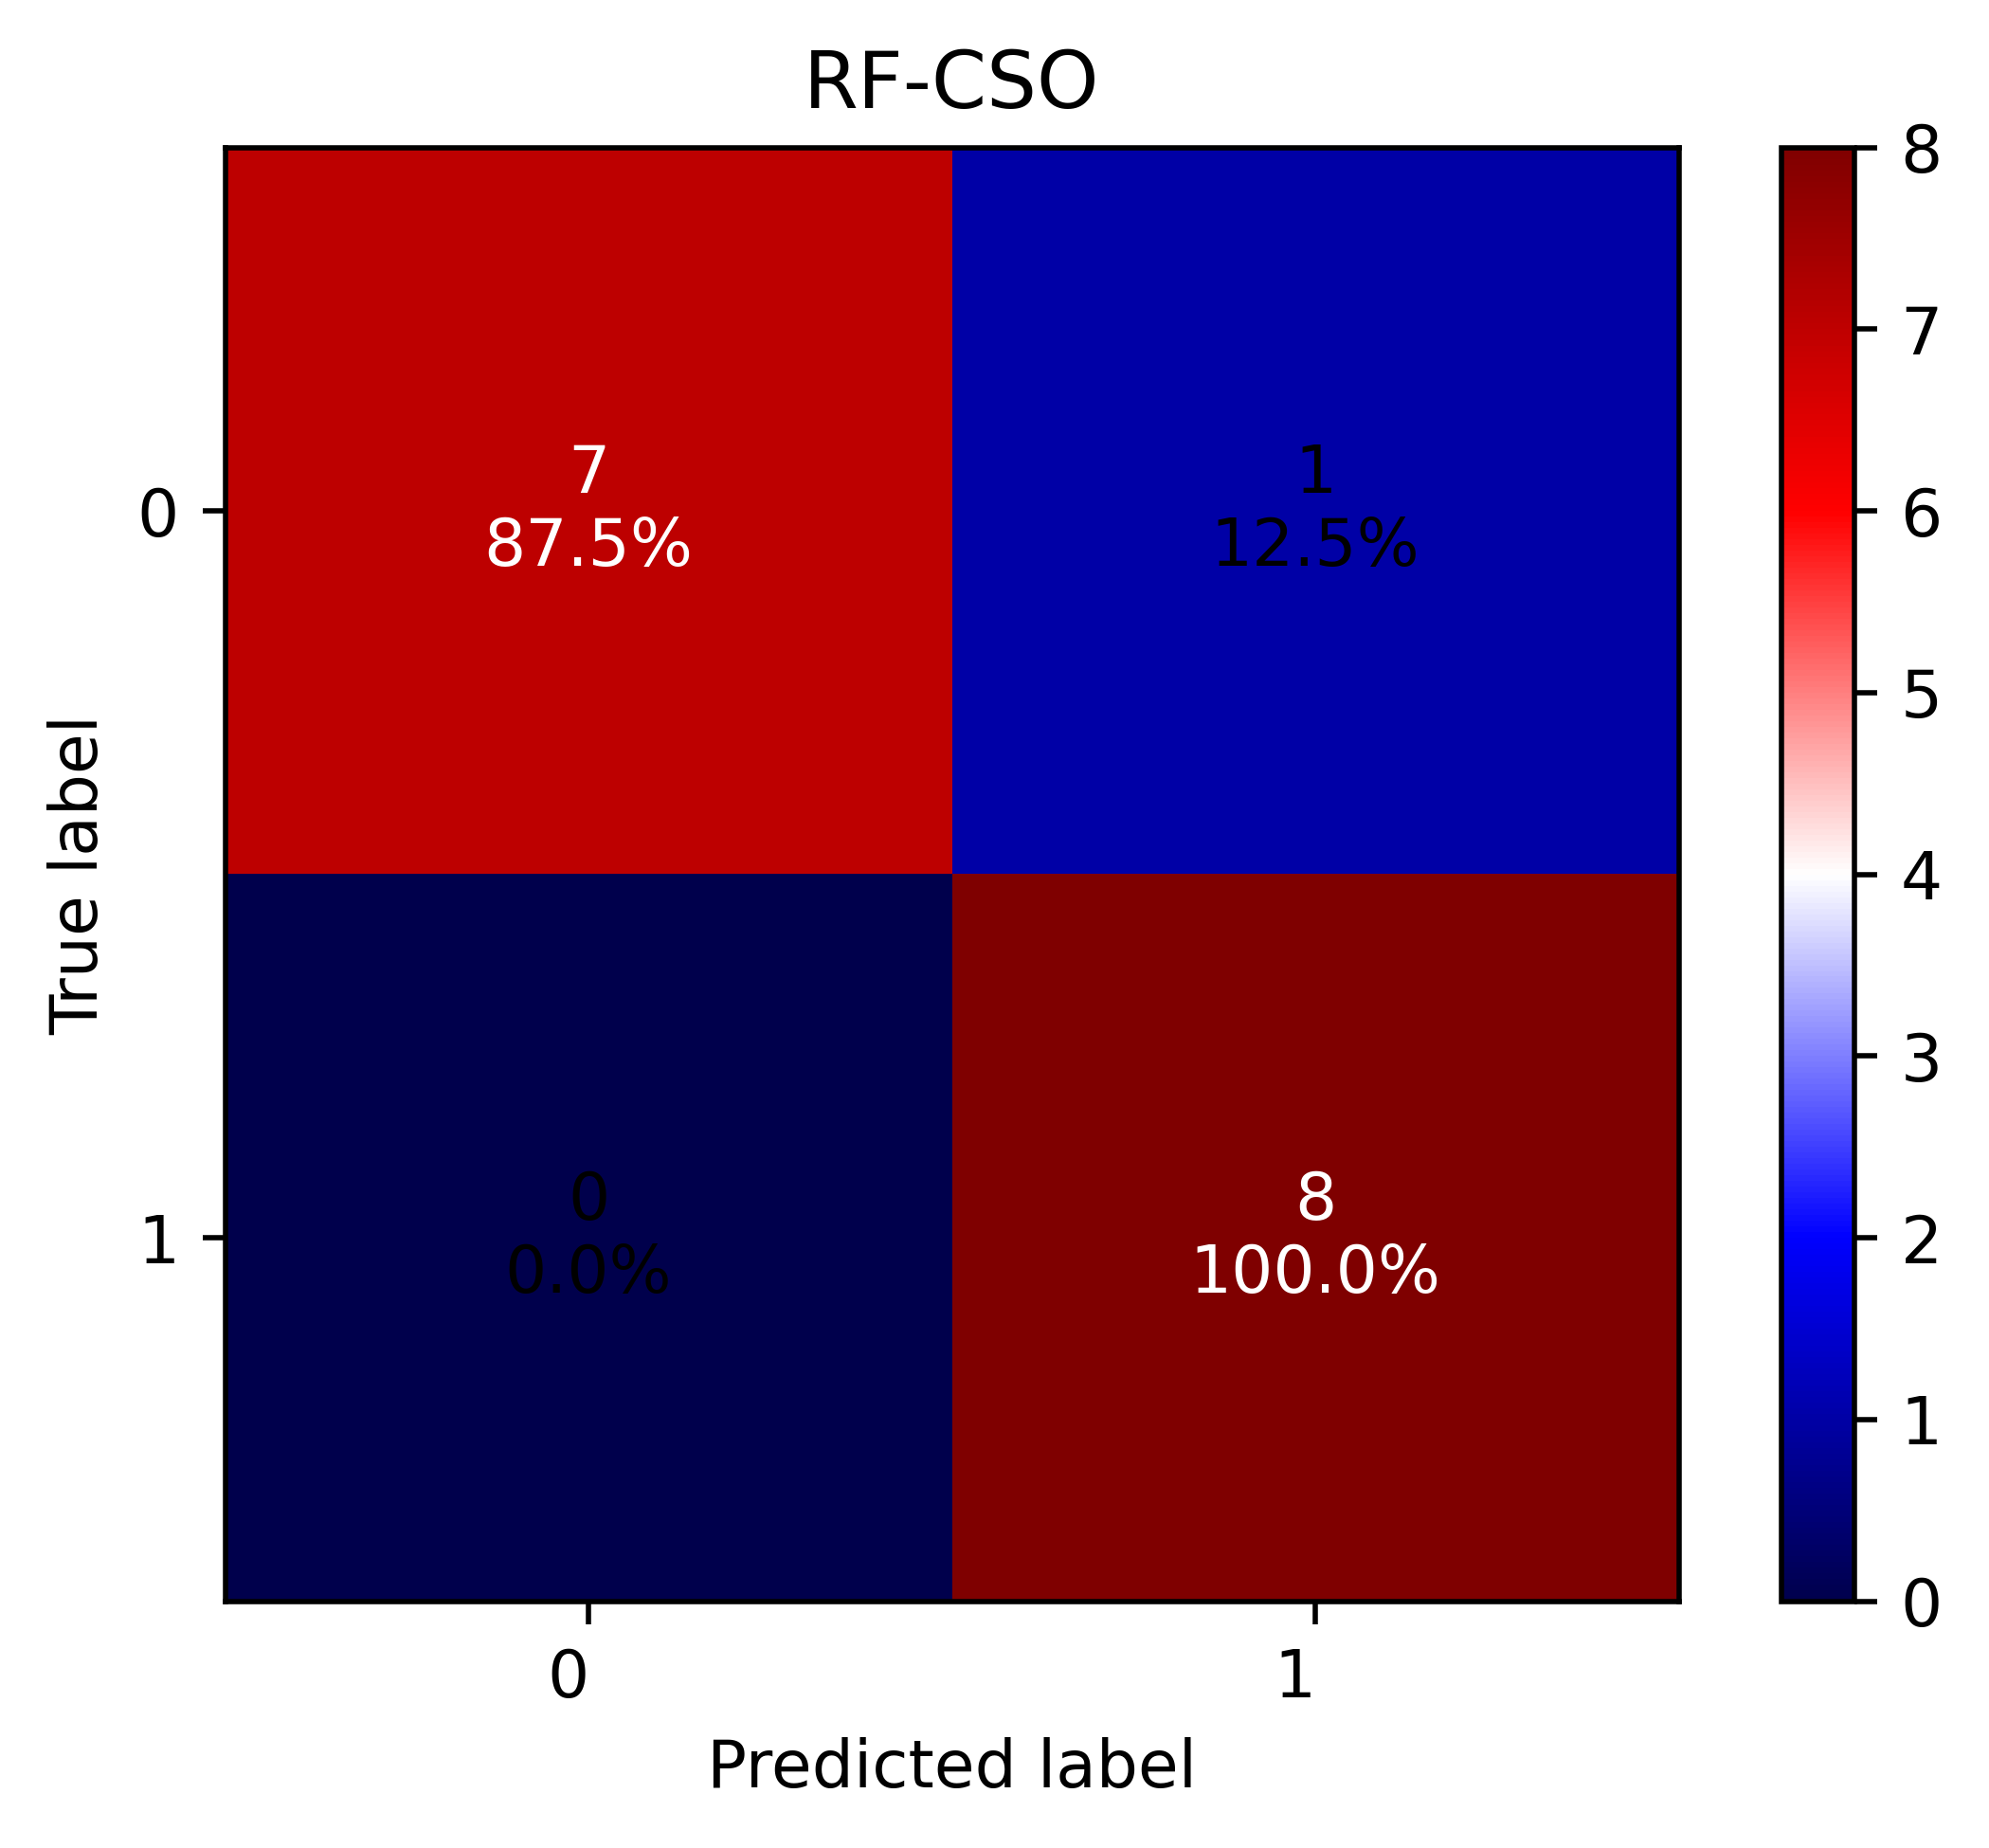

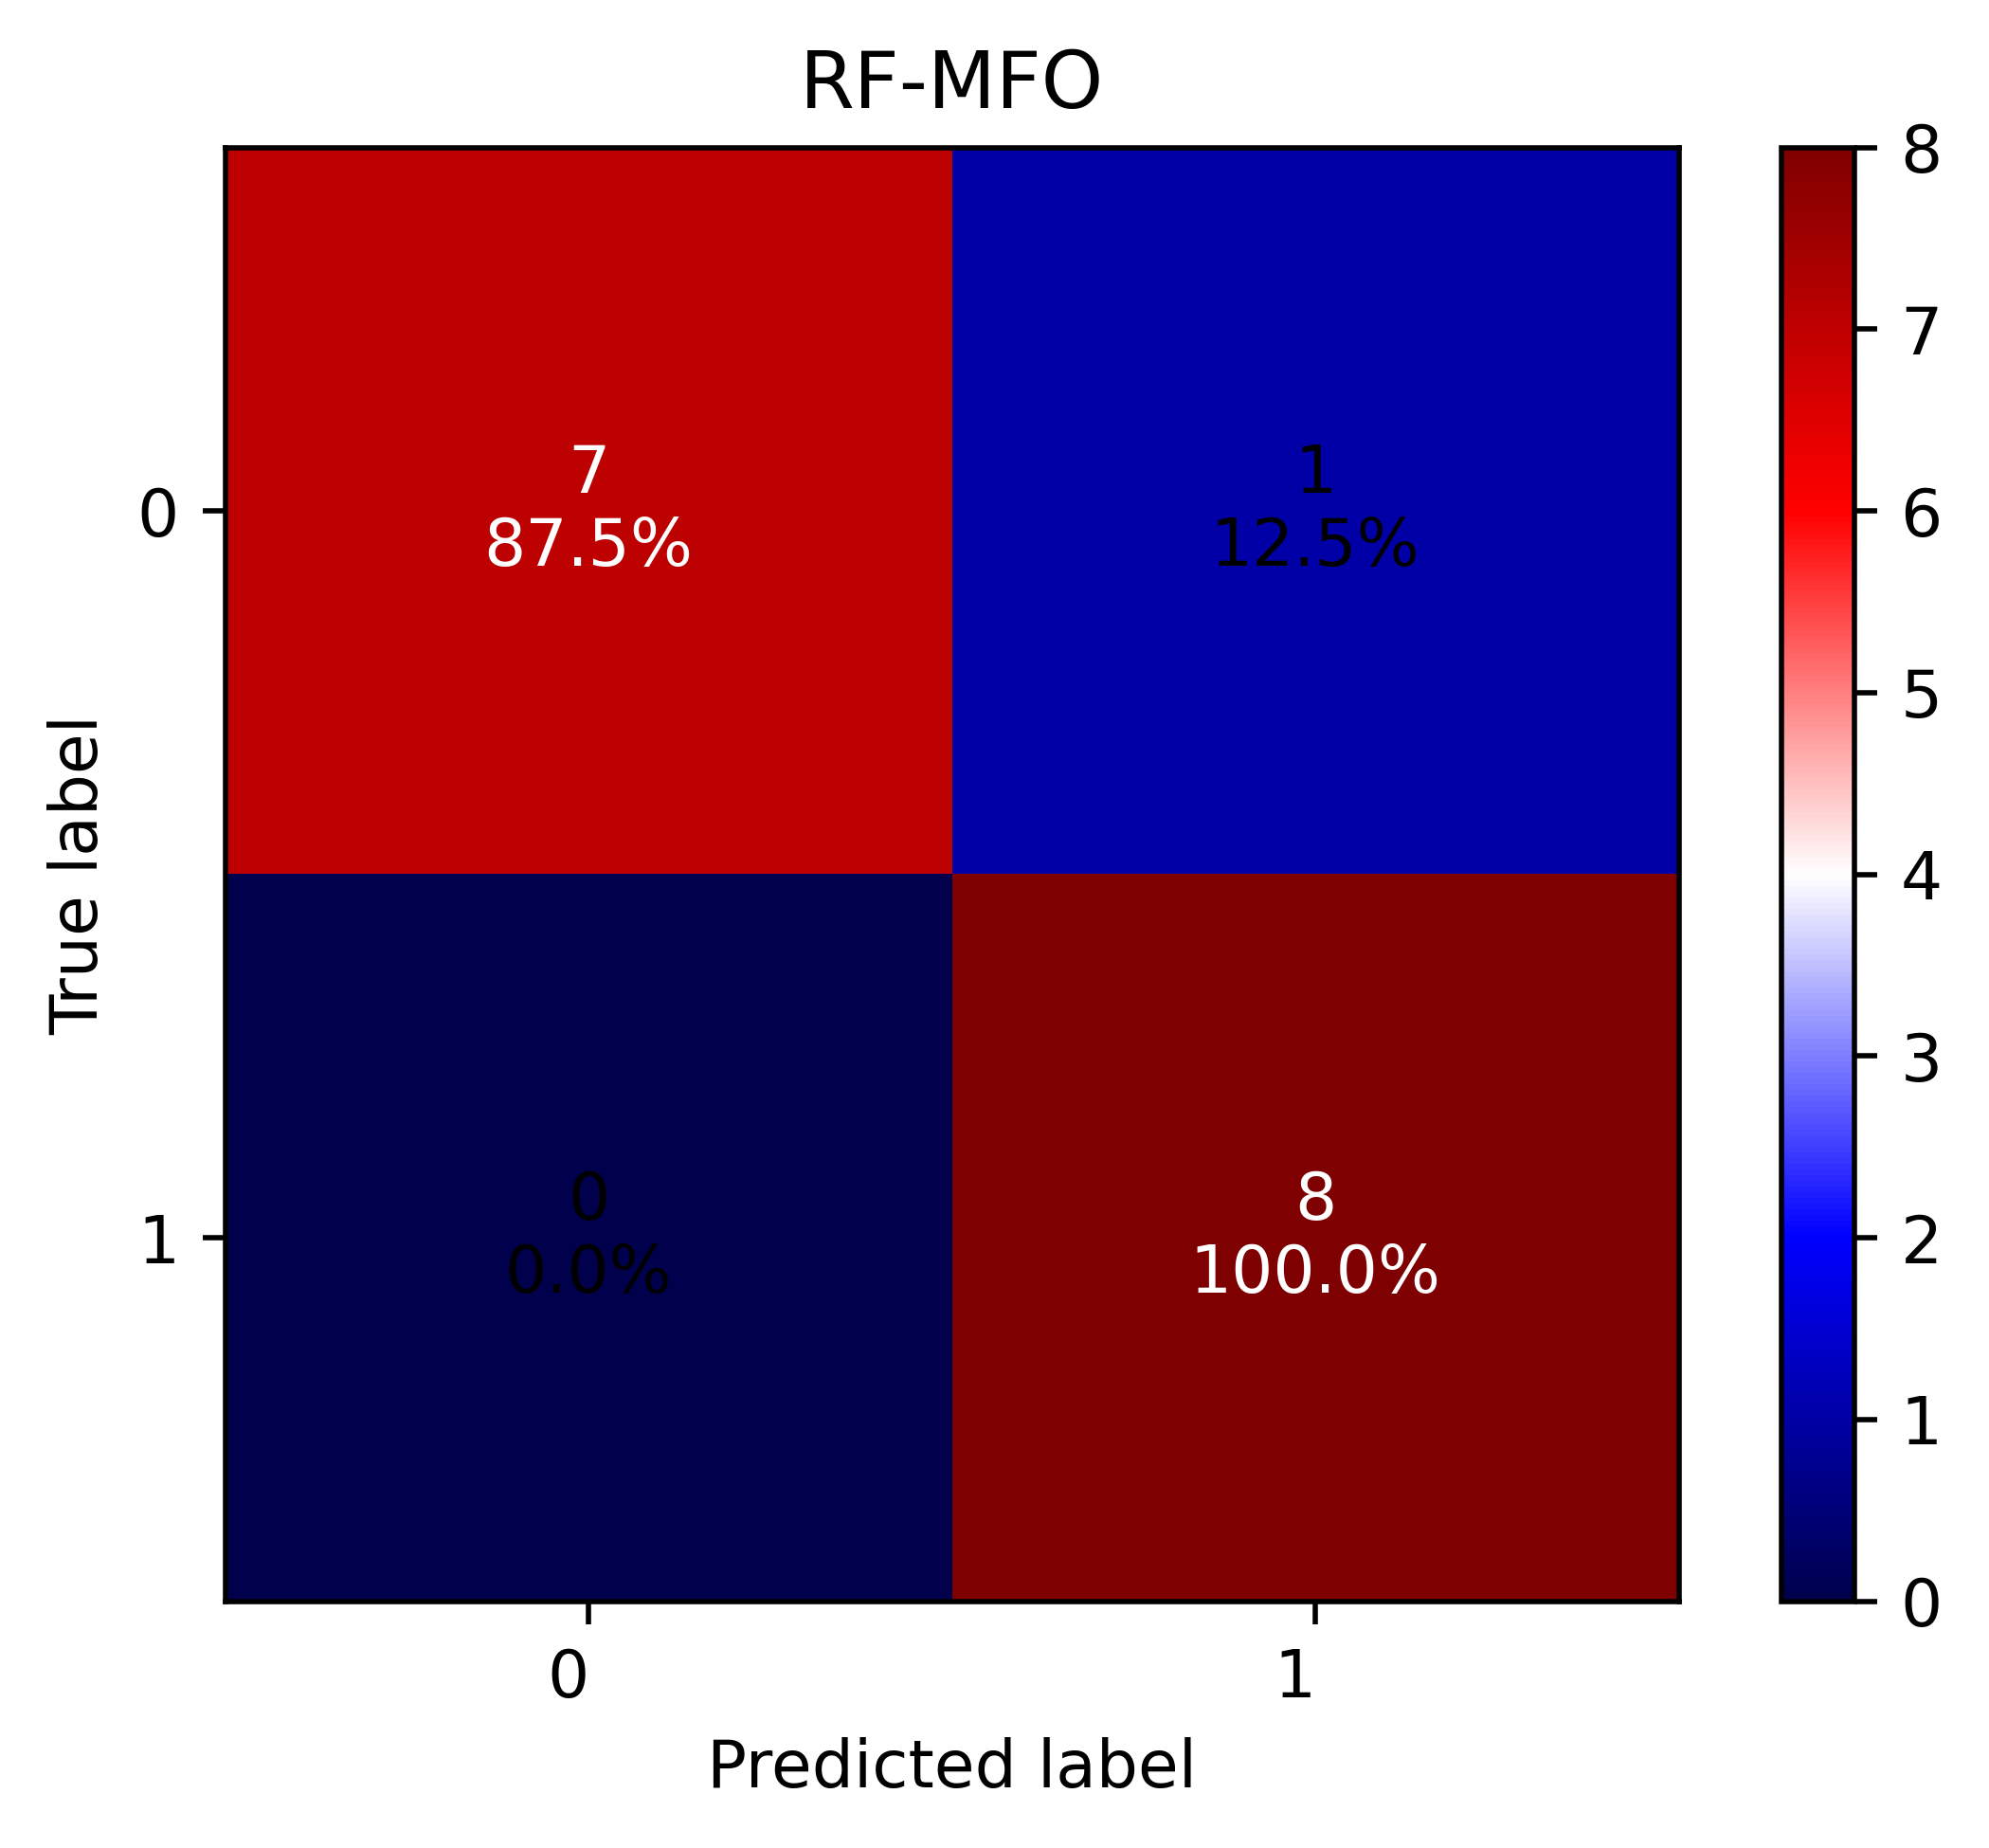

In [ ]:
# prompt: plot the confusion matrix graph for ANN, ANN-CSO and ANN-MFO separately, SHOWING THE digits and PERCENTAGES one on top of the other in the same graph

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, title, threshold):
    cm = confusion_matrix( (y_true >= threshold).astype(int), (y_pred >= threshold).astype(int))
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    fig, ax = plt.subplots(figsize=(5, 4), dpi=500)
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.seismic)
    ax.figure.colorbar(im, ax=ax)

    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=['0', '1'], yticklabels=['0', '1'],
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=0, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.0f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt) + '\n' + format(cm_percentage[i,j],'.1f') + '%',
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()


# Example usage (replace with your actual data and predictions):
threshold = np.mean(y_test)
plot_confusion_matrix(y_test, rf_test_predictions, "RF", threshold)
plot_confusion_matrix(y_test, rf_cso_test_predictions, "RF-CSO", threshold)
plot_confusion_matrix(y_test, rf_mfo_test_predictions, "RF-MFO", threshold)

AUPRC for RF: 0.9444444444444444
AUPRC for RF-CSO: 0.9444444444444444
AUPRC for RF-MFO: 0.9444444444444444


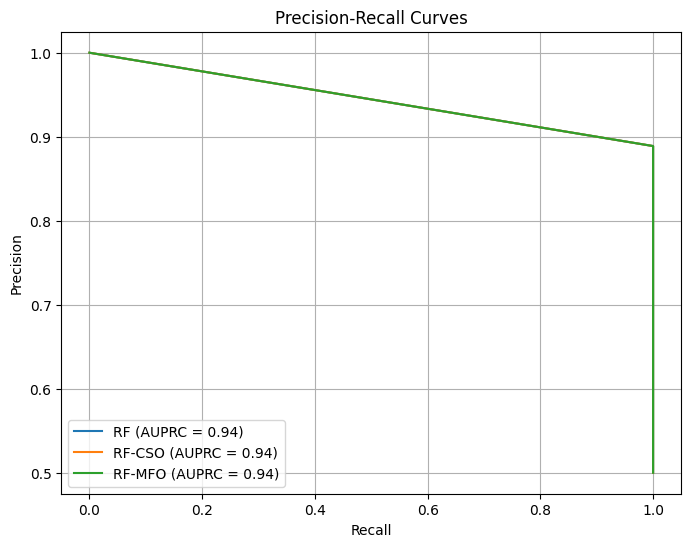

In [ ]:
# prompt: COMPUTE Area under the precision-Recall curve (AUPRC) for RF, RF-CSO AND RF-MFO PLOT THE GRAPHS. MAKE IT BINARY

from sklearn.metrics import precision_recall_curve, auc

# ... (Your existing code)

# Calculate precision-recall curves and AUPRC
precision_rf, recall_rf, _ = precision_recall_curve(y_test > threshold, rf_test_predictions > threshold)
auprc_rf = auc(recall_rf, precision_rf)

precision_rf_cso, recall_rf_cso, _ = precision_recall_curve(y_test > threshold, rf_cso_test_predictions > threshold)
auprc_rf_cso = auc(recall_rf_cso, precision_rf_cso)

precision_rf_mfo, recall_rf_mfo, _ = precision_recall_curve(y_test > threshold, rf_mfo_test_predictions > threshold)
auprc_rf_mfo = auc(recall_rf_mfo, precision_rf_mfo)

# Print AUPRC scores
print(f"AUPRC for RF: {auprc_rf}")
print(f"AUPRC for RF-CSO: {auprc_rf_cso}")
print(f"AUPRC for RF-MFO: {auprc_rf_mfo}")

# Plot precision-recall curves
plt.figure(figsize=(8, 6))
plt.plot(recall_rf, precision_rf, label=f'RF (AUPRC = {auprc_rf:.2f})')
plt.plot(recall_rf_cso, precision_rf_cso, label=f'RF-CSO (AUPRC = {auprc_rf_cso:.2f})')
plt.plot(recall_rf_mfo, precision_rf_mfo, label=f'RF-MFO (AUPRC = {auprc_rf_mfo:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

AUPRC for RF: 0.9444444444444444


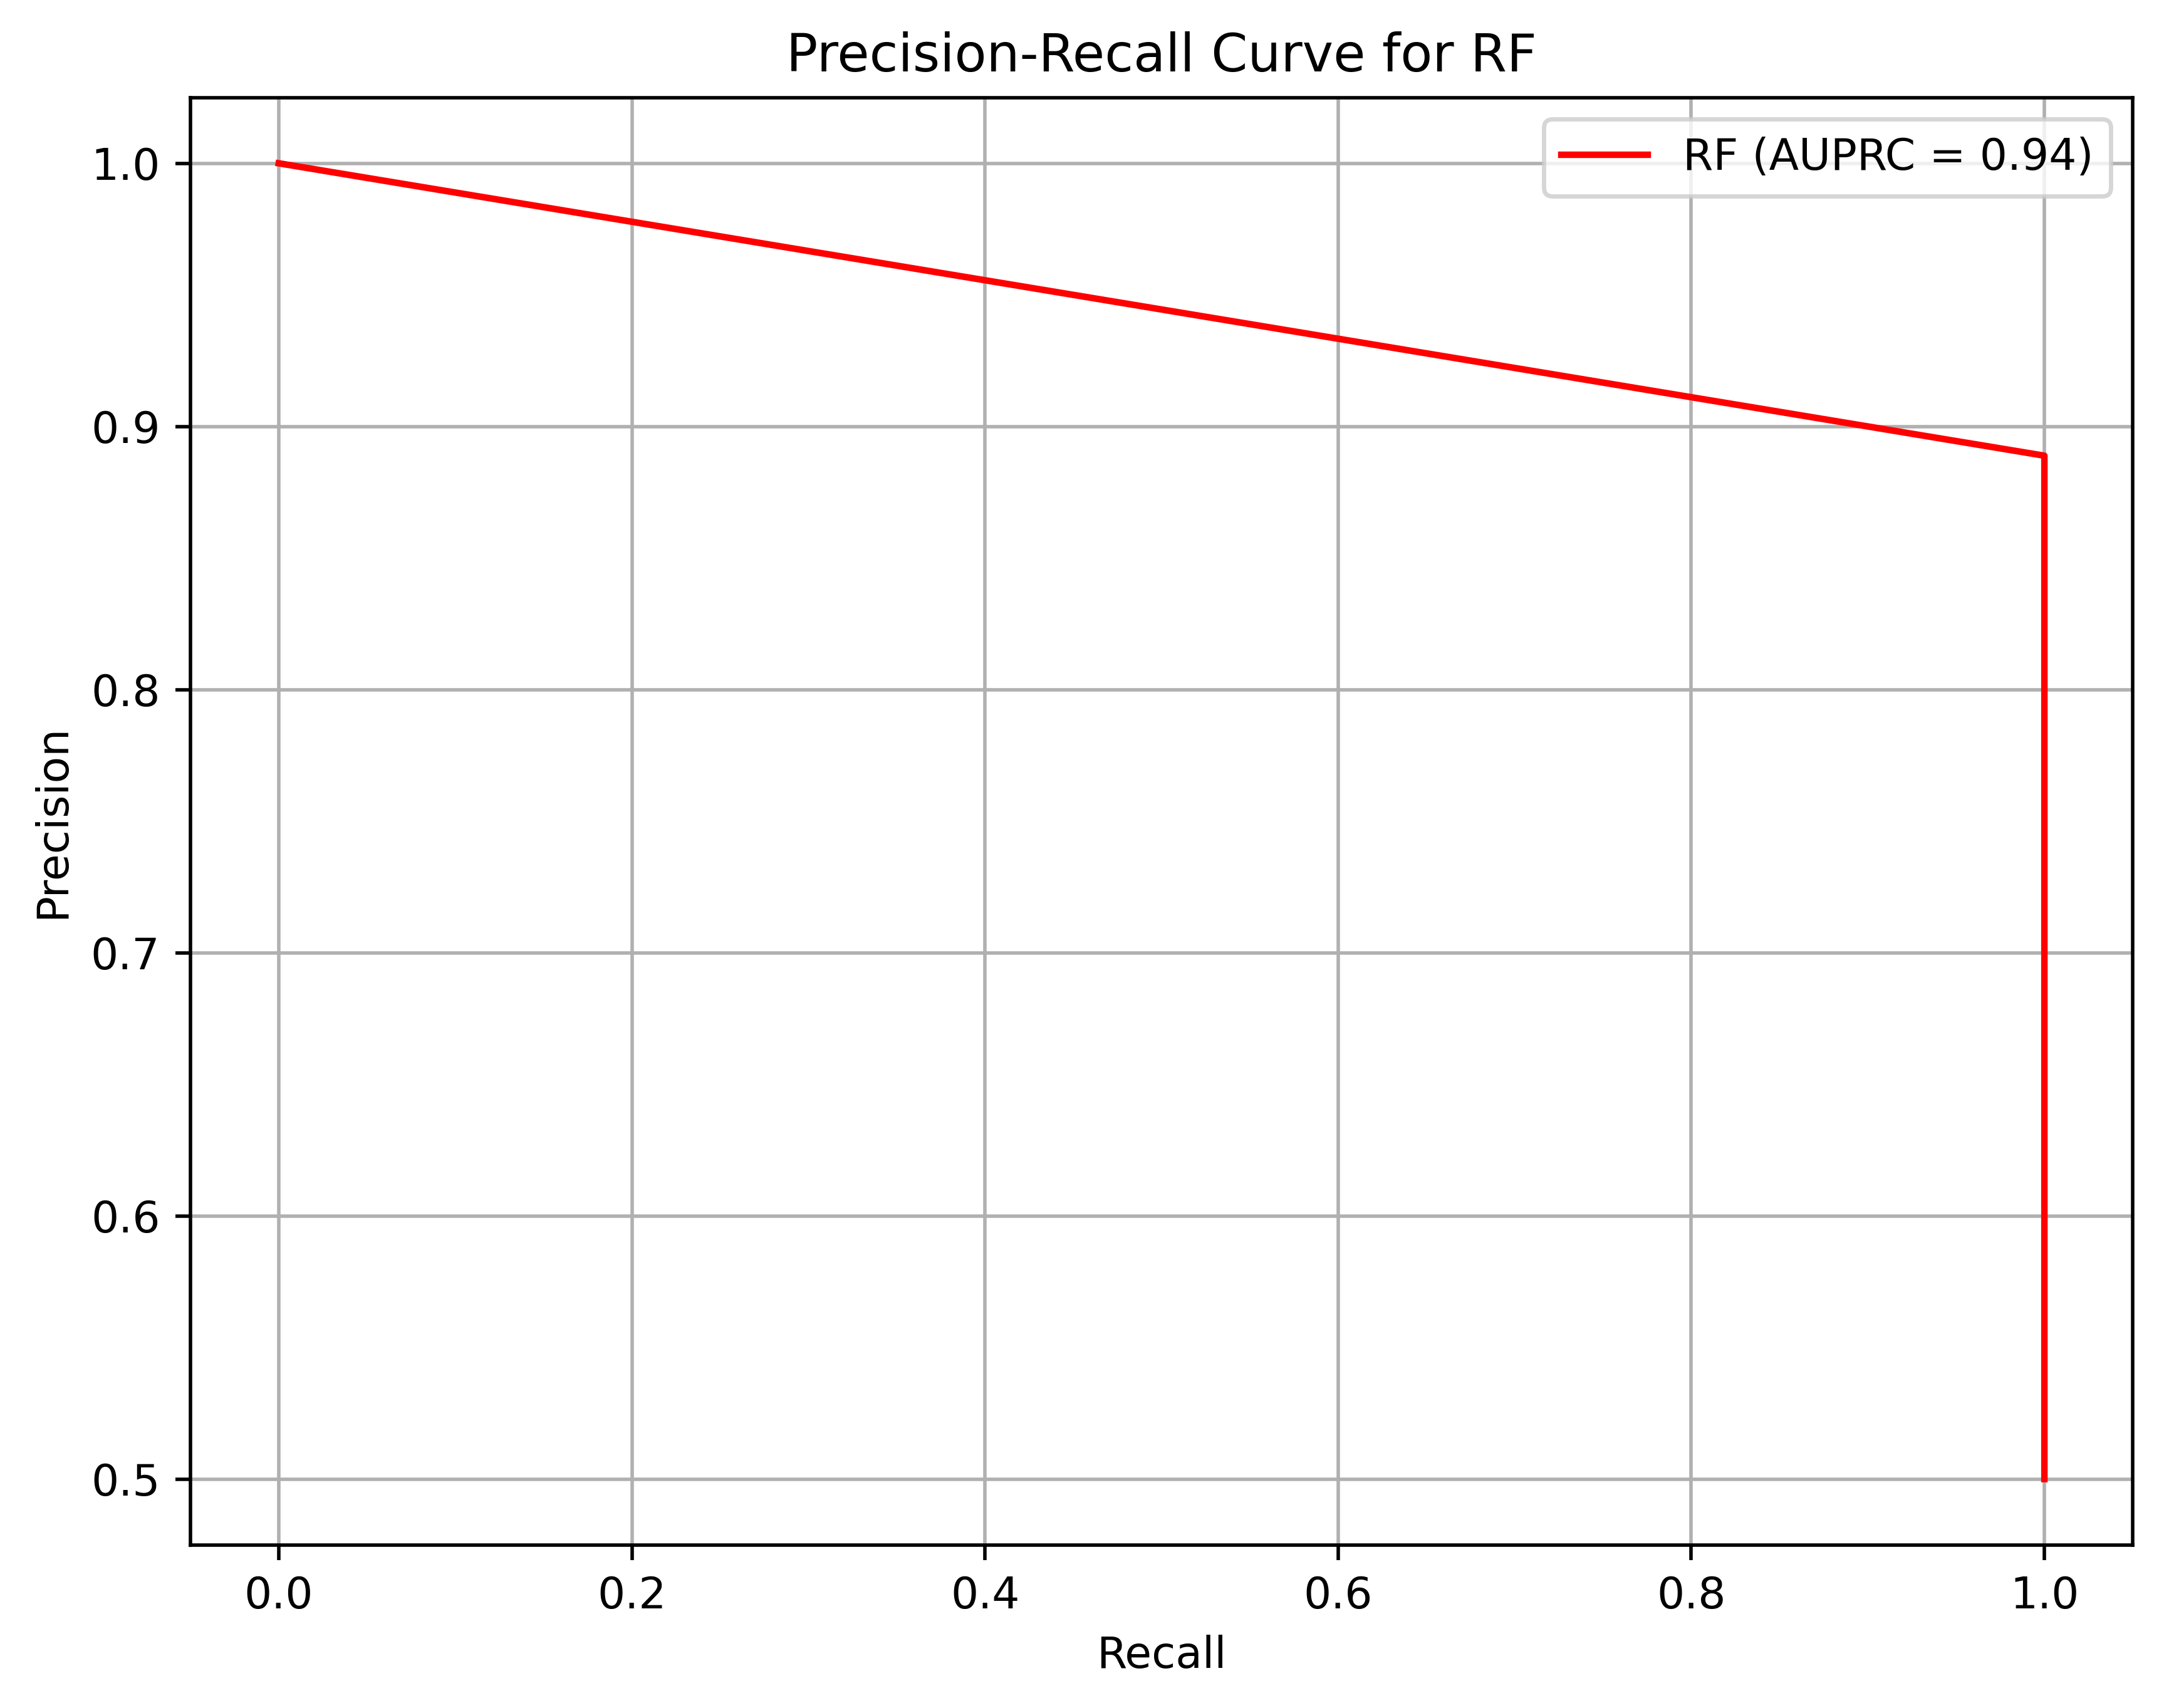

In [ ]:
# prompt: COMPUTE Area under the precision-Recall curve (AUPRC) for RF only, PLOT THE GRAPHS. MAKE IT BINARY

# Calculate precision-recall curves and AUPRC for RF only
precision_rf, recall_rf, _ = precision_recall_curve(y_test > threshold, rf_test_predictions > threshold)
auprc_rf = auc(recall_rf, precision_rf)

# Print AUPRC score for RF only
print(f"AUPRC for RF: {auprc_rf}")

# Plot precision-recall curve for RF only
plt.figure(figsize=(8, 6), dpi=500)
plt.plot(recall_rf, precision_rf, color='red', label=f'RF (AUPRC = {auprc_rf:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for RF')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

AUPRC for RF-CSO: 0.9444444444444444


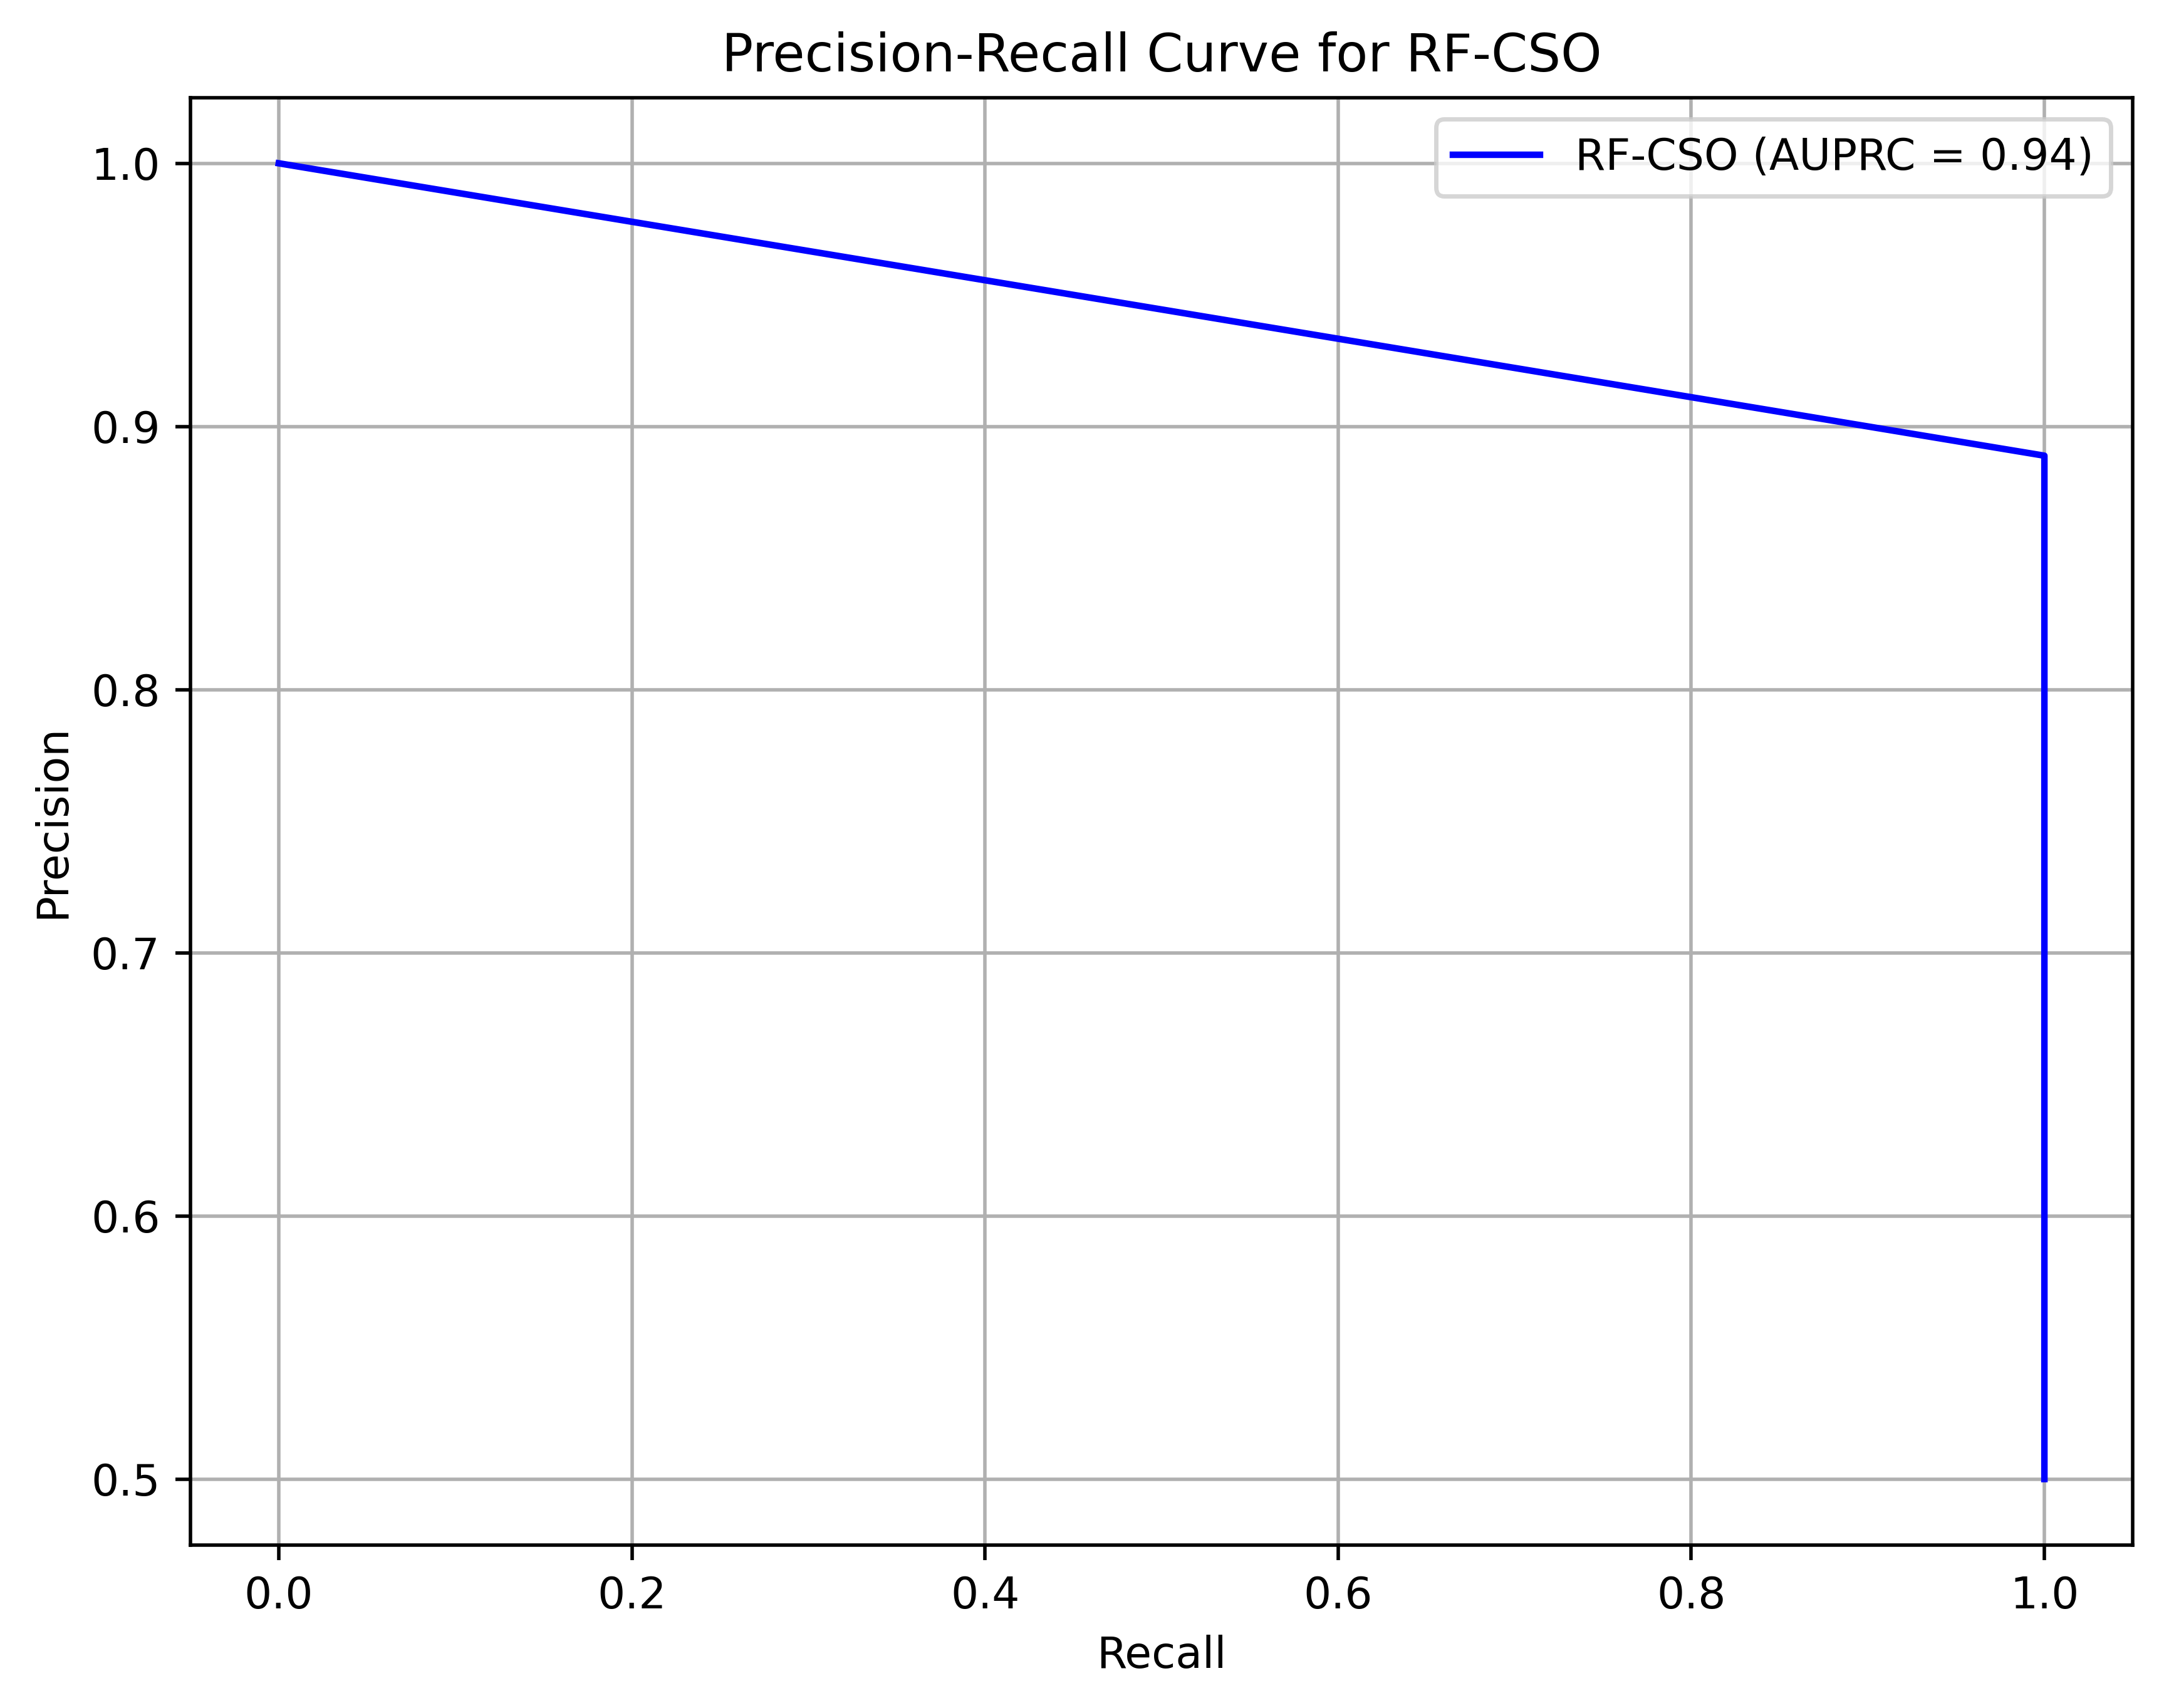

In [ ]:
# prompt: COMPUTE Area under the precision-Recall curve (AUPRC) for RF-CSO only, PLOT THE GRAPHS. MAKE IT BINARY

# Calculate precision-recall curve and AUPRC for RF-CSO only
precision_rf_cso, recall_rf_cso, _ = precision_recall_curve(y_test > threshold, rf_cso_test_predictions > threshold)
auprc_rf_cso = auc(recall_rf_cso, precision_rf_cso)

# Print AUPRC score for RF-CSO only
print(f"AUPRC for RF-CSO: {auprc_rf_cso}")

# Plot precision-recall curve for RF-CSO only
plt.figure(figsize=(8, 6), dpi=500)
plt.plot(recall_rf_cso, precision_rf_cso, color='blue', label=f'RF-CSO (AUPRC = {auprc_rf_cso:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for RF-CSO')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

AUPRC for RF-MFO: 0.9444444444444444


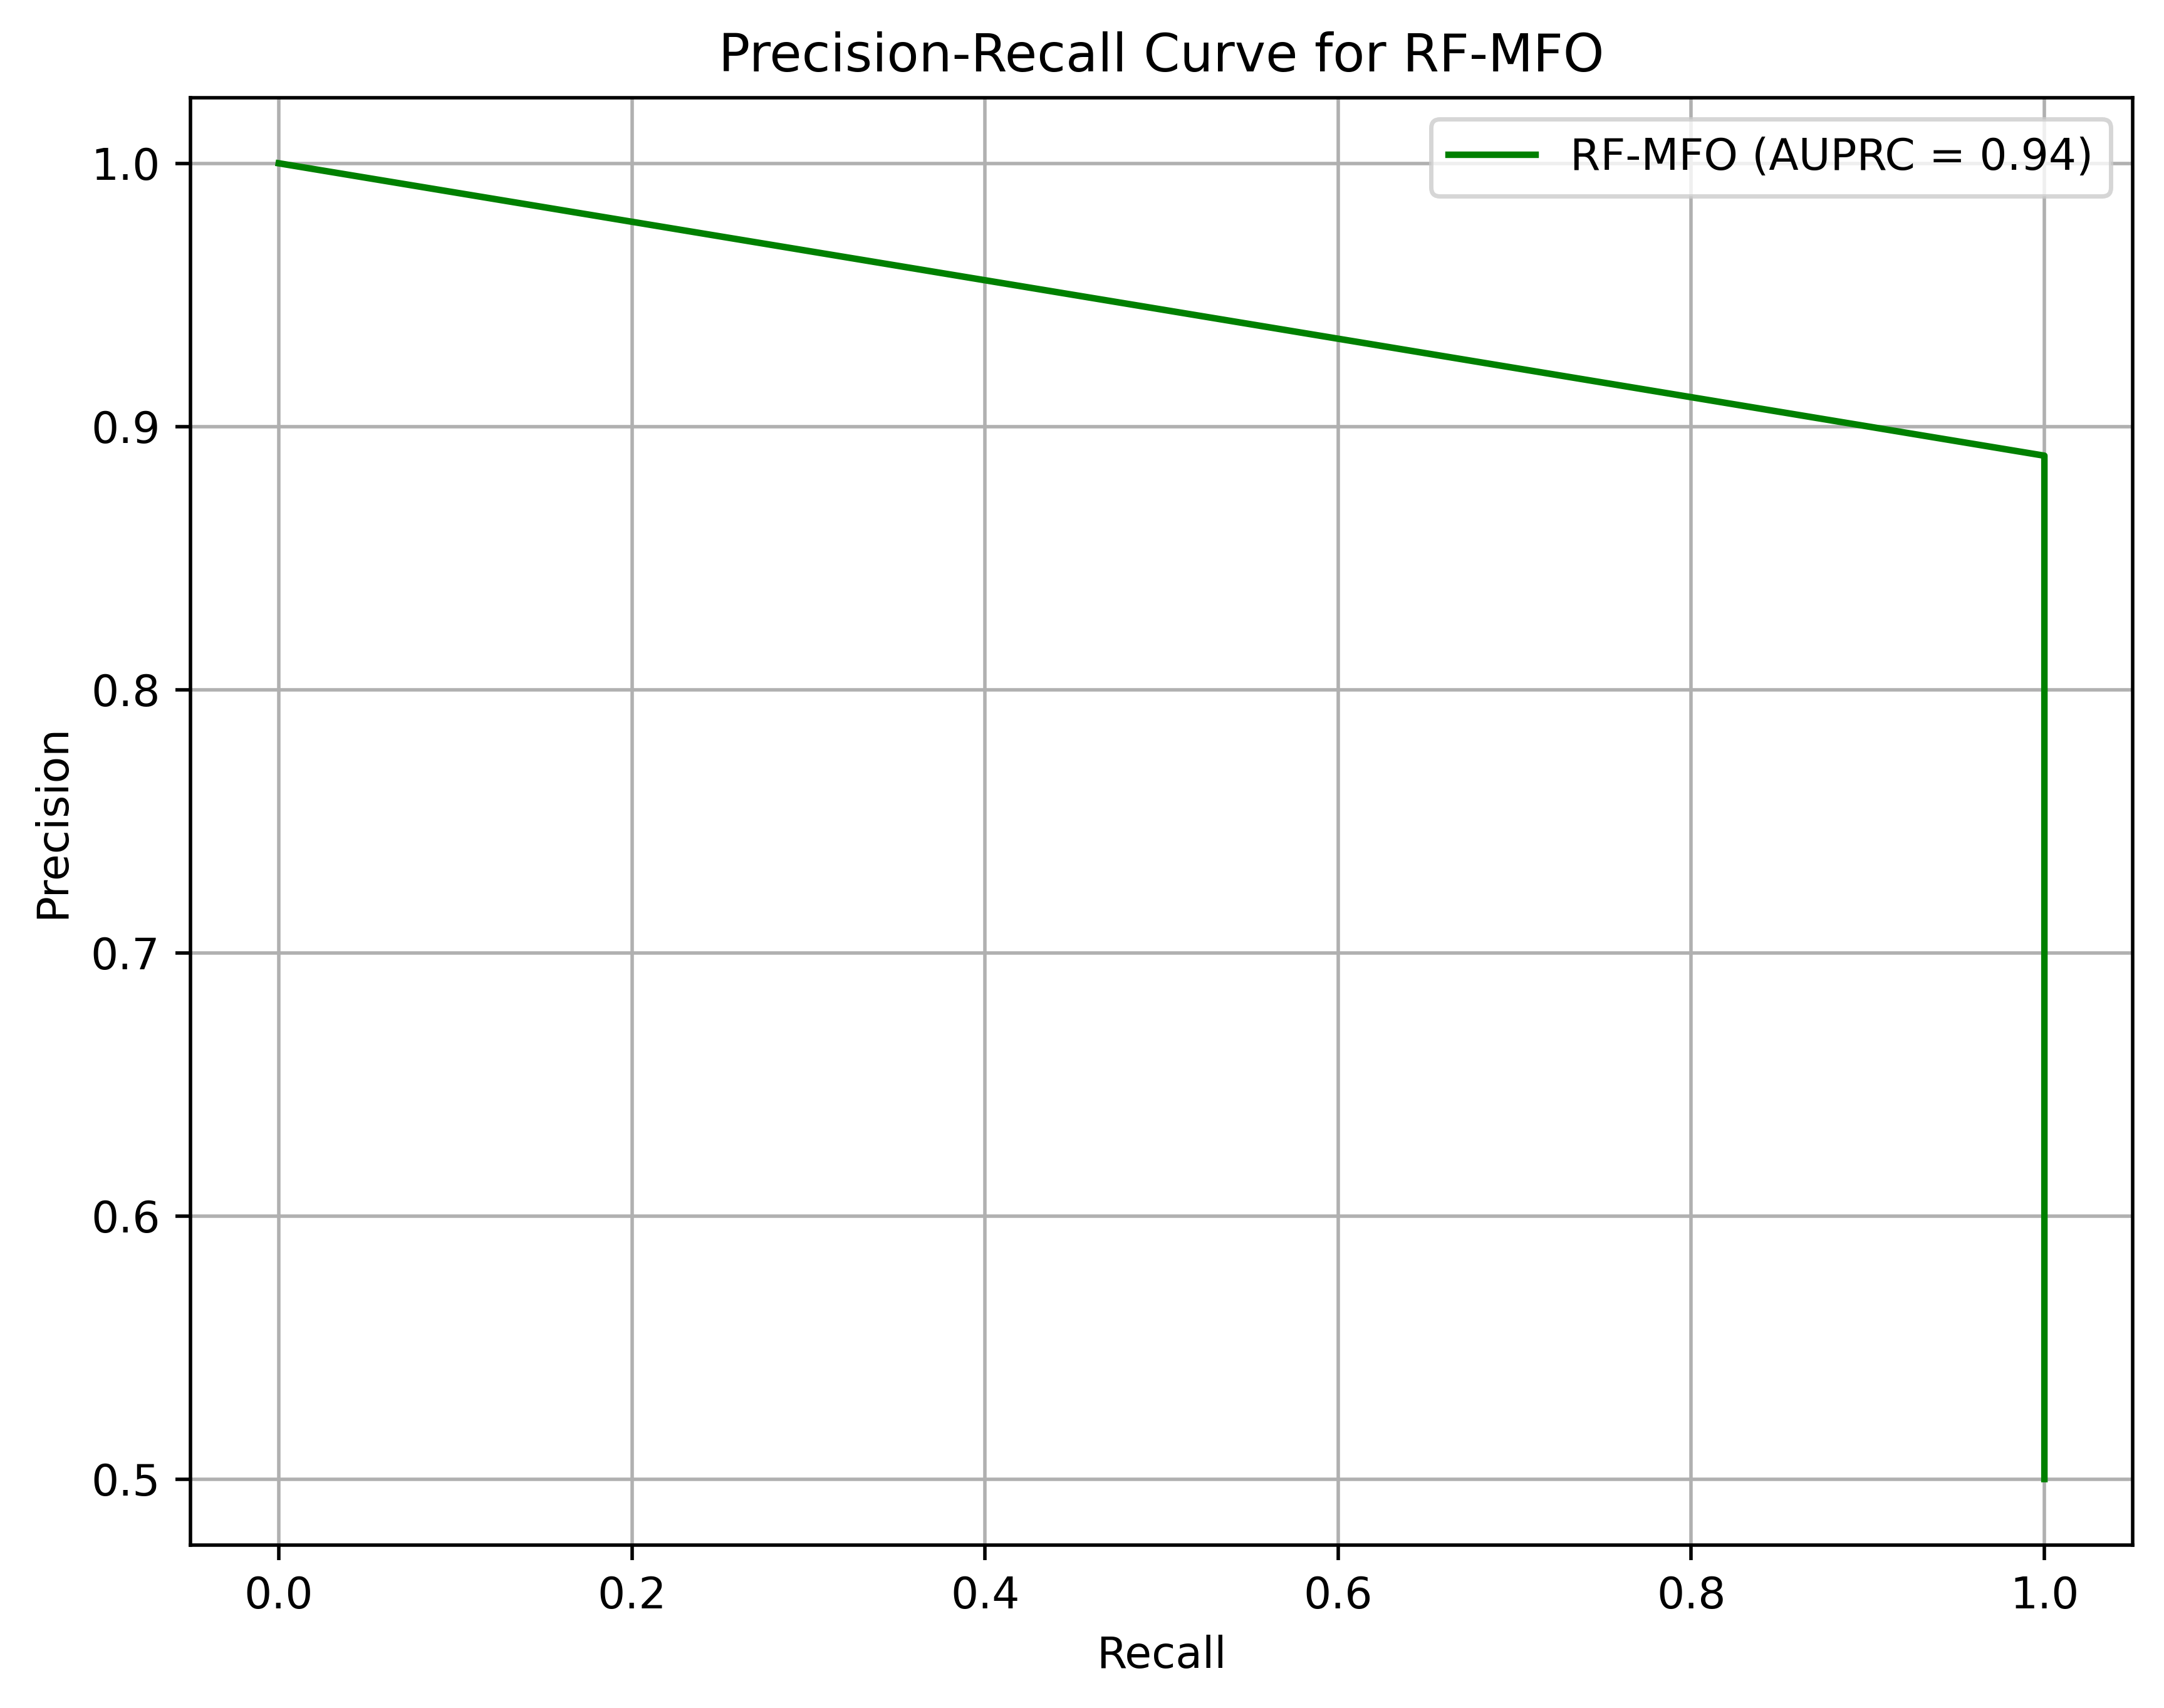

In [ ]:
# prompt: COMPUTE Area under the precision-Recall curve (AUPRC) for RF-MFO only, PLOT THE GRAPHS. MAKE IT BINARY

# Calculate precision-recall curve and AUPRC for RF-MFO only
precision_rf_mfo, recall_rf_mfo, _ = precision_recall_curve(y_test > threshold, rf_mfo_test_predictions > threshold)
auprc_rf_mfo = auc(recall_rf_mfo, precision_rf_mfo)

# Print AUPRC score for RF-MFO only
print(f"AUPRC for RF-MFO: {auprc_rf_mfo}")

# Plot precision-recall curve for RF-MFO only
plt.figure(figsize=(8, 6), dpi=500)
plt.plot(recall_rf_mfo, precision_rf_mfo, color='green', label=f'RF-MFO (AUPRC = {auprc_rf_mfo:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for RF-MFO')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

AUPRC for RF: 0.9444444444444444
AUPRC for RF-CSO: 0.9444444444444444
AUPRC for RF-MFO: 0.9444444444444444


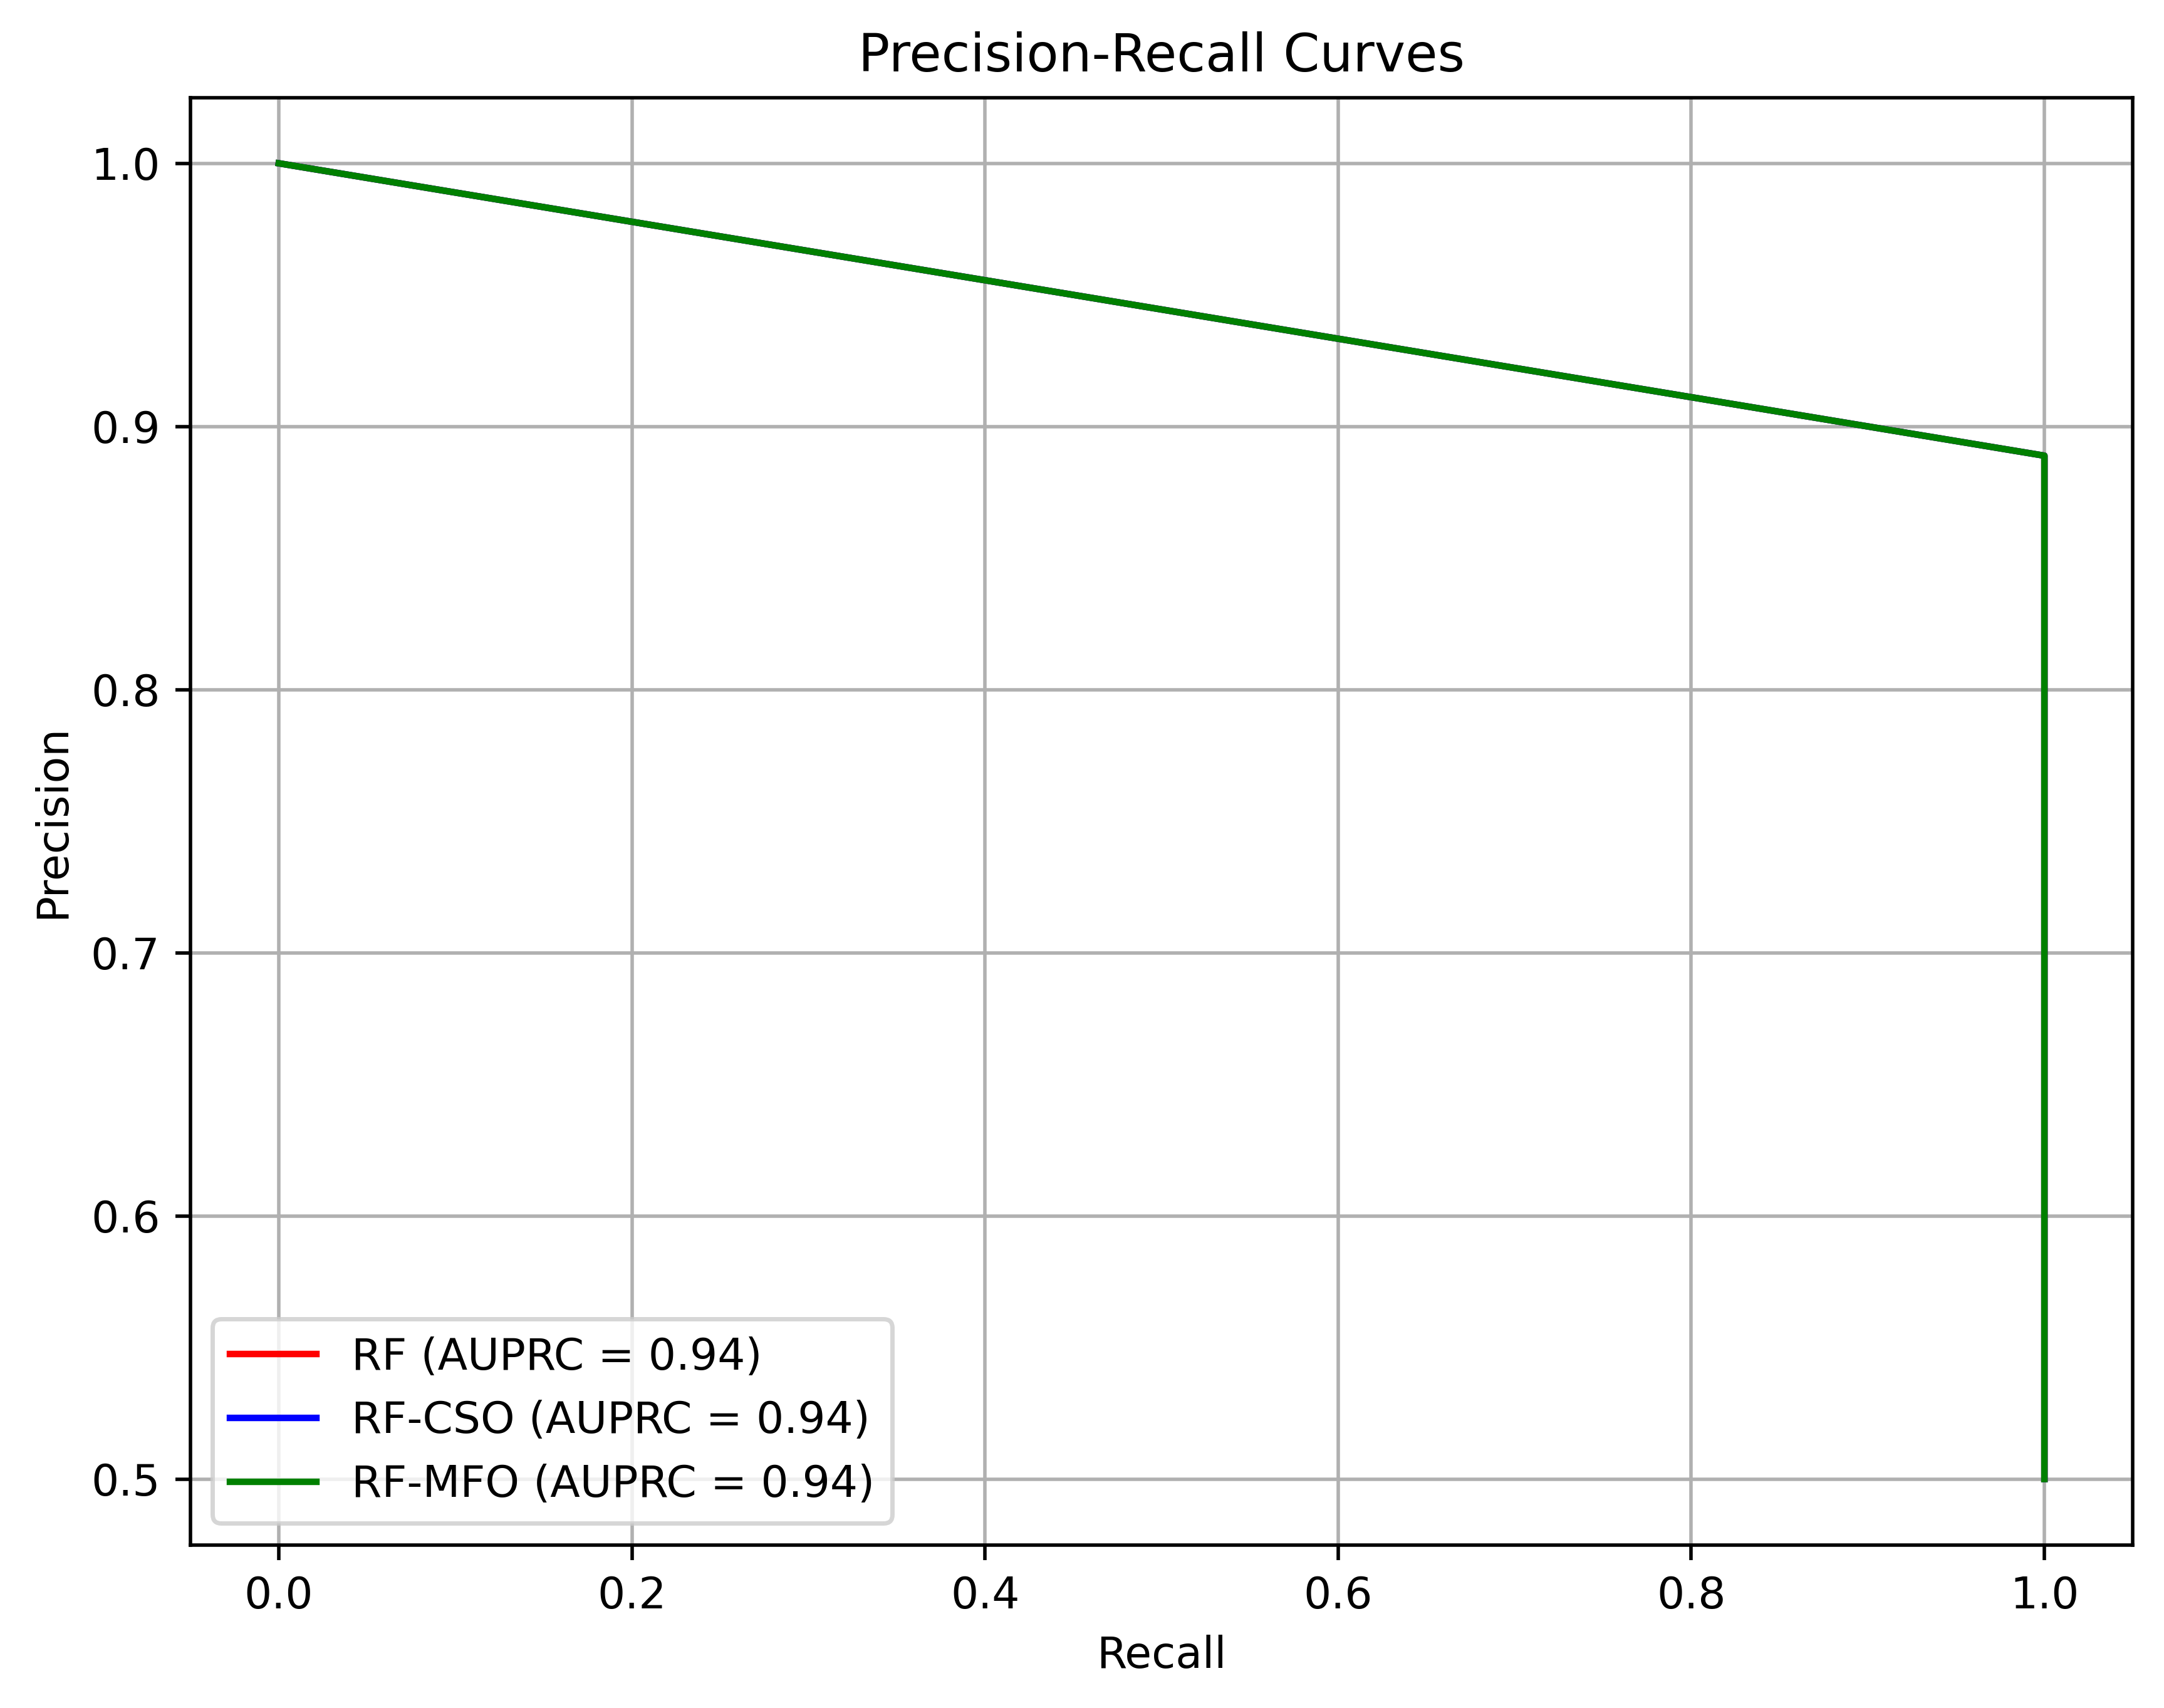

In [ ]:
# prompt: COMPUTE Area under the precision-Recall curve (AUPRC) for RF, RF-CSO AND RF-MFO PLOT THE GRAPHS. MAKE IT BINARY

# Calculate precision-recall curves and AUPRC
precision_rf, recall_rf, _ = precision_recall_curve(y_test > threshold, rf_test_predictions > threshold)
auprc_rf = auc(recall_rf, precision_rf)

precision_rf_cso, recall_rf_cso, _ = precision_recall_curve(y_test > threshold, rf_cso_test_predictions > threshold)
auprc_rf_cso = auc(recall_rf_cso, precision_rf_cso)

precision_rf_mfo, recall_rf_mfo, _ = precision_recall_curve(y_test > threshold, rf_mfo_test_predictions > threshold)
auprc_rf_mfo = auc(recall_rf_mfo, precision_rf_mfo)

# Print AUPRC scores
print(f"AUPRC for RF: {auprc_rf}")
print(f"AUPRC for RF-CSO: {auprc_rf_cso}")
print(f"AUPRC for RF-MFO: {auprc_rf_mfo}")

# Plot precision-recall curves
plt.figure(figsize=(8, 6), dpi=500)
plt.plot(recall_rf, precision_rf, color='red', label=f'RF (AUPRC = {auprc_rf:.2f})')
plt.plot(recall_rf_cso, precision_rf_cso, color='blue', label=f'RF-CSO (AUPRC = {auprc_rf_cso:.2f})')
plt.plot(recall_rf_mfo, precision_rf_mfo, color='green', label=f'RF-MFO (AUPRC = {auprc_rf_mfo:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

In [ ]:
# prompt: Compute COHEN'S KAPPA, MATTHEWS CORRELATION COEFFICIENT (MCC), and Normalized Mutual Information (NMI) FOR THE MODELS

from sklearn.metrics import cohen_kappa_score, matthews_corrcoef
from sklearn.metrics import normalized_mutual_info_score

# Assuming you have already calculated the confusion matrices (cm_rf, cm_rf_cso, cm_rf_mfo) and have y_test and predictions.
# ... (Your existing code for model training and prediction)

def calculate_metrics(y_true, y_pred, threshold):
    binarized_y_true = (y_true > threshold).astype(int)
    binarized_y_pred = (y_pred > threshold).astype(int)

    kappa = cohen_kappa_score(binarized_y_true, binarized_y_pred)
    mcc = matthews_corrcoef(binarized_y_true, binarized_y_pred)
    nmi = normalized_mutual_info_score(binarized_y_true, binarized_y_pred)

    return kappa, mcc, nmi

# Calculate metrics for each model
threshold = np.median(y_test)  # You can adjust the threshold as needed

kappa_rf, mcc_rf, nmi_rf = calculate_metrics(y_test, rf_test_predictions, threshold)
kappa_rf_cso, mcc_rf_cso, nmi_rf_cso = calculate_metrics(y_test, rf_cso_test_predictions, threshold)
kappa_rf_mfo, mcc_rf_mfo, nmi_rf_mfo = calculate_metrics(y_test, rf_mfo_test_predictions, threshold)


print("RF Metrics:")
print("Cohen's Kappa:", kappa_rf)
print("Matthews Correlation Coefficient:", mcc_rf)
print("Normalized Mutual Information:", nmi_rf)

print("\nRF-CSO Metrics:")
print("Cohen's Kappa:", kappa_rf_cso)
print("Matthews Correlation Coefficient:", mcc_rf_cso)
print("Normalized Mutual Information:", nmi_rf_cso)

print("\nRF-MFO Metrics:")
print("Cohen's Kappa:", kappa_rf_mfo)
print("Matthews Correlation Coefficient:", mcc_rf_mfo)
print("Normalized Mutual Information:", nmi_rf_mfo)

RF Metrics:
Cohen's Kappa: 0.875
Matthews Correlation Coefficient: 0.8819171036881969
Normalized Mutual Information: 0.7209909991431913

RF-CSO Metrics:
Cohen's Kappa: 0.875
Matthews Correlation Coefficient: 0.8819171036881969
Normalized Mutual Information: 0.7209909991431913

RF-MFO Metrics:
Cohen's Kappa: 0.875
Matthews Correlation Coefficient: 0.8819171036881969
Normalized Mutual Information: 0.7209909991431913


In [ ]:
# prompt: FAIRNESS METRICS FOR THE MODELS

# Assuming y_test and your model predictions are available:
# y_test: True labels
# rf_test_predictions: Predictions from the RF model
# rf_mfo_test_predictions: Predictions from the RF-MFO model

# Calculate AIC (already present in your code)

# ... (Your existing code for AIC calculation)


# Statistical Tests (new code)
from scipy.stats import ttest_ind

# Example using t-test to compare model performance
# (Replace with your preferred statistical test and relevant metrics)
t_statistic, p_value = ttest_ind(y_test, rf_test_predictions)
print(f"T-test (RF): t-statistic={t_statistic:.3f}, p-value={p_value:.3f}")

t_statistic, p_value = ttest_ind(y_test, rf_cso_test_predictions)
print(f"T-test (RF-CSO): t-statistic={t_statistic:.3f}, p-value={p_value:.3f}")

t_statistic, p_value = ttest_ind(y_test, rf_mfo_test_predictions)
print(f"T-test (RF-MFO): t-statistic={t_statistic:.3f}, p-value={p_value:.3f}")


T-test (RF): t-statistic=-0.623, p-value=0.538
T-test (RF-CSO): t-statistic=-0.623, p-value=0.538
T-test (RF-MFO): t-statistic=-0.623, p-value=0.538


ValueError: All arrays must be of the same length

RF: ECE=0.0556, Brier Score=0.0625
RF-CSO: ECE=0.0556, Brier Score=0.0625
RF-MFO: ECE=0.0556, Brier Score=0.0625


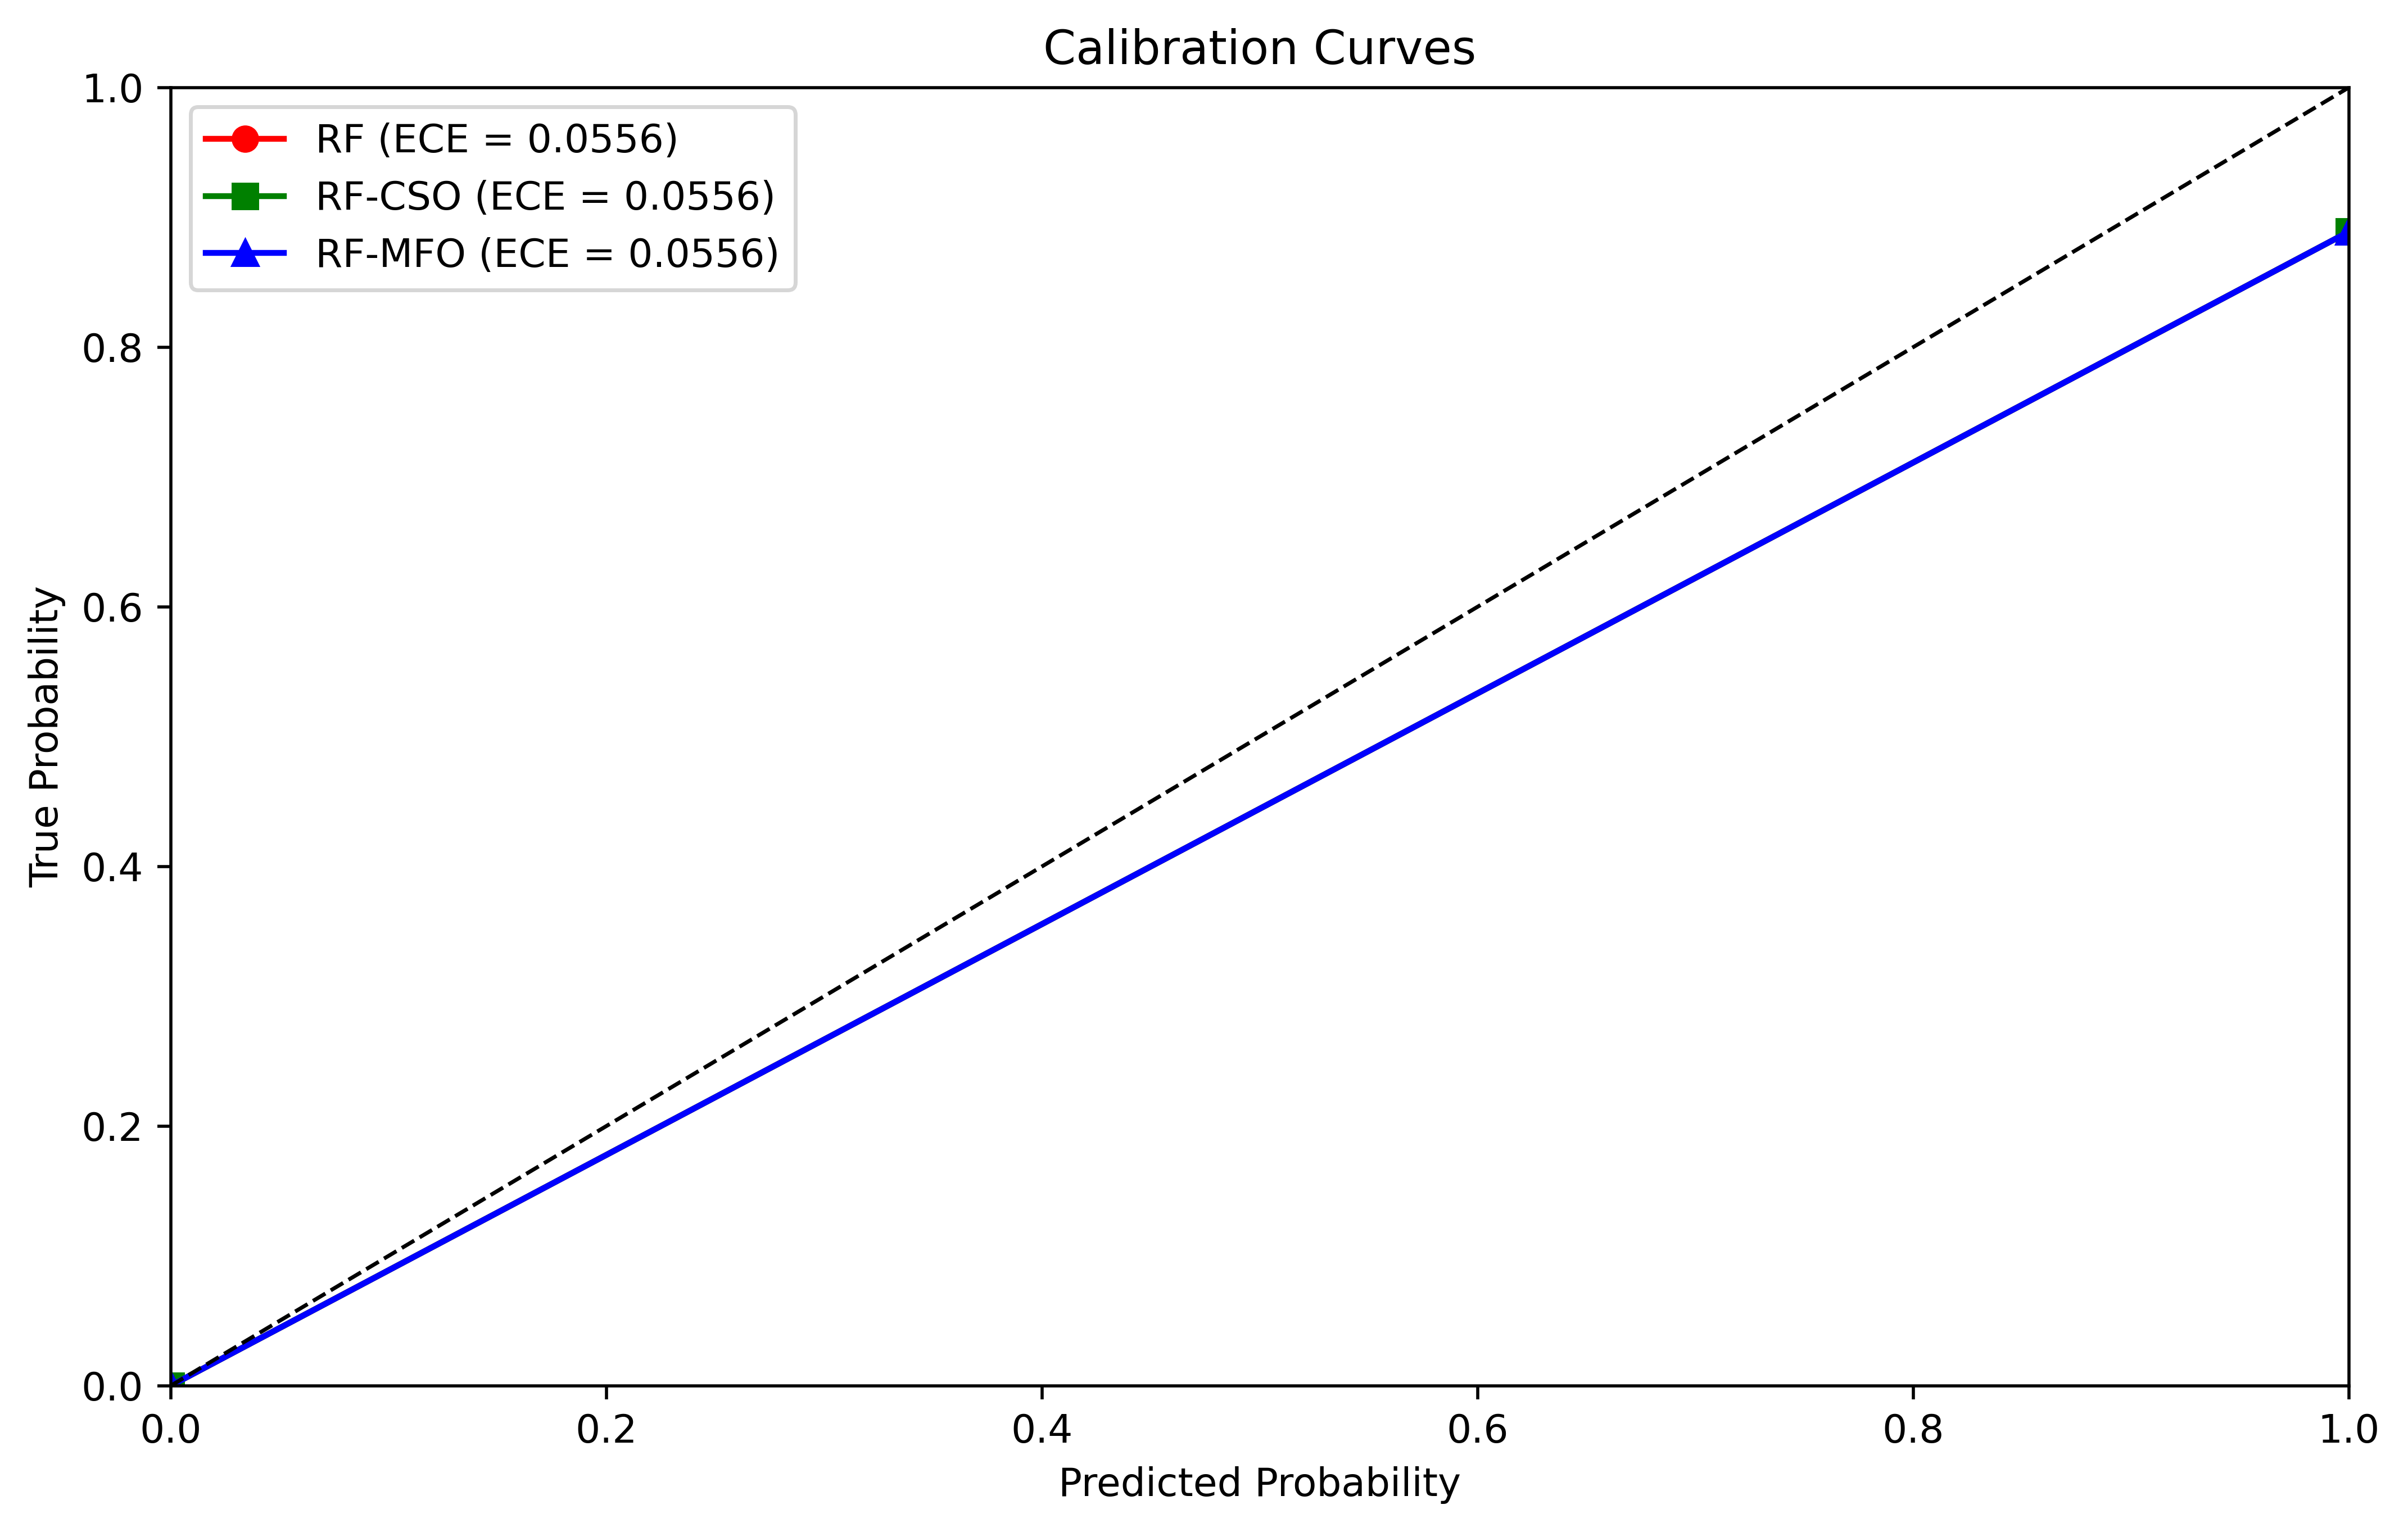

ValueError: All arrays must be of the same length

In [ ]:
# prompt: COMPUTE THE PREDICTION CONFIDENCE INTERVAL, EXPECTED CALIBRATION ERROR(ECE) AND BRIER SCORE FOR THE MODELS

from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
import matplotlib.pyplot as plt

# ... (Your existing code)

def calculate_calibration_metrics(y_true, y_prob):
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=10)
    ece = np.mean(np.abs(prob_true - prob_pred))
    brier = brier_score_loss(y_true, y_prob)
    return prob_true, prob_pred, ece, brier


# Assuming your models output probabilities (if not, you need to adjust this)
# Example:  rf_probs = rf.predict_proba(X_test)[:, 1] if your model has predict_proba

# Calculate confidence interval (using the method described earlier)
# ... (Your confidence interval code)

# Example for RF (assuming it outputs probabilities for each class):
# rf_probs = rf.predict_proba(X_test)[:, 1]  # Probability for the positive class

# Example for RF-CSO (assuming it also outputs probabilities):
# rf_cso_probs = rf_cso.predict_proba(X_test)[:, 1]

# Example for RF-MFO (assuming it also outputs probabilities):
# rf_mfo_probs = rf_mfo.predict_proba(X_test)[:, 1]

# Calculate ECE and Brier score
# Create a threshold for binarizing the predictions (e.g., median)
threshold = np.median(y_test)

# Binarize the true values
binarized_y_test = (y_test > threshold).astype(int)

# Binarize the predictions for each model
binarized_rf_preds = (rf_test_predictions > threshold).astype(int)
binarized_rf_cso_preds = (rf_cso_test_predictions > threshold).astype(int)
binarized_rf_mfo_preds = (rf_mfo_test_predictions > threshold).astype(int)

prob_true_rf, prob_pred_rf, ece_rf, brier_rf = calculate_calibration_metrics(binarized_y_test, binarized_rf_preds)
prob_true_rf_cso, prob_pred_rf_cso, ece_rf_cso, brier_rf_cso = calculate_calibration_metrics(binarized_y_test, binarized_rf_cso_preds)
prob_true_rf_mfo, prob_pred_rf_mfo, ece_rf_mfo, brier_rf_mfo = calculate_calibration_metrics(binarized_y_test, binarized_rf_mfo_preds)

print(f"RF: ECE={ece_rf:.4f}, Brier Score={brier_rf:.4f}")
print(f"RF-CSO: ECE={ece_rf_cso:.4f}, Brier Score={brier_rf_cso:.4f}")
print(f"RF-MFO: ECE={ece_rf_mfo:.4f}, Brier Score={brier_rf_mfo:.4f}")


# Plotting Calibration Curves
plt.figure(figsize=(10, 6), dpi=500)
plt.plot(prob_pred_rf, prob_true_rf, color='red', marker='o', label=f'RF (ECE = {ece_rf:.4f})')
plt.plot(prob_pred_rf_cso, prob_true_rf_cso, color='green', marker='s', label=f'RF-CSO (ECE = {ece_rf_cso:.4f})')
plt.plot(prob_pred_rf_mfo, prob_true_rf_mfo, color='blue', marker='^', label=f'RF-MFO (ECE = {ece_rf_mfo:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color='k')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.title('Calibration Curves')
plt.legend()
plt.show()


In [ ]:
# prompt: compute balanced classification rate (BCR) and Geometric mean (G-Mean) for the models

def calculate_bcr_gmean(cm):
    TN, FP, FN, TP = cm.ravel()
    BCR = 0.5 * (TP / (TP + FN) + TN / (TN + FP))
    G_mean = np.sqrt((TP / (TP + FN)) * (TN / (TN + FP)))
    return BCR, G_mean

# Assuming cm_rf, cm_rf_cso, and cm_rf_mfo are already defined

bcr_rf, gmean_rf = calculate_bcr_gmean(cm_rf)
bcr_rf_cso, gmean_rf_cso = calculate_bcr_gmean(cm_rf_cso)
bcr_rf_mfo, gmean_rf_mfo = calculate_bcr_gmean(cm_rf_mfo)

print(f"RF: BCR={bcr_rf:.4f}, G-mean={gmean_rf:.4f}")
print(f"RF-CSO: BCR={bcr_rf_cso:.4f}, G-mean={gmean_rf_cso:.4f}")
print(f"RF-MFO: BCR={bcr_rf_mfo:.4f}, G-mean={gmean_rf_mfo:.4f}")


RF: BCR=0.9375, G-mean=0.9354
RF-CSO: BCR=0.9375, G-mean=0.9354
RF-MFO: BCR=0.9375, G-mean=0.9354


ValueError: All arrays must be of the same length

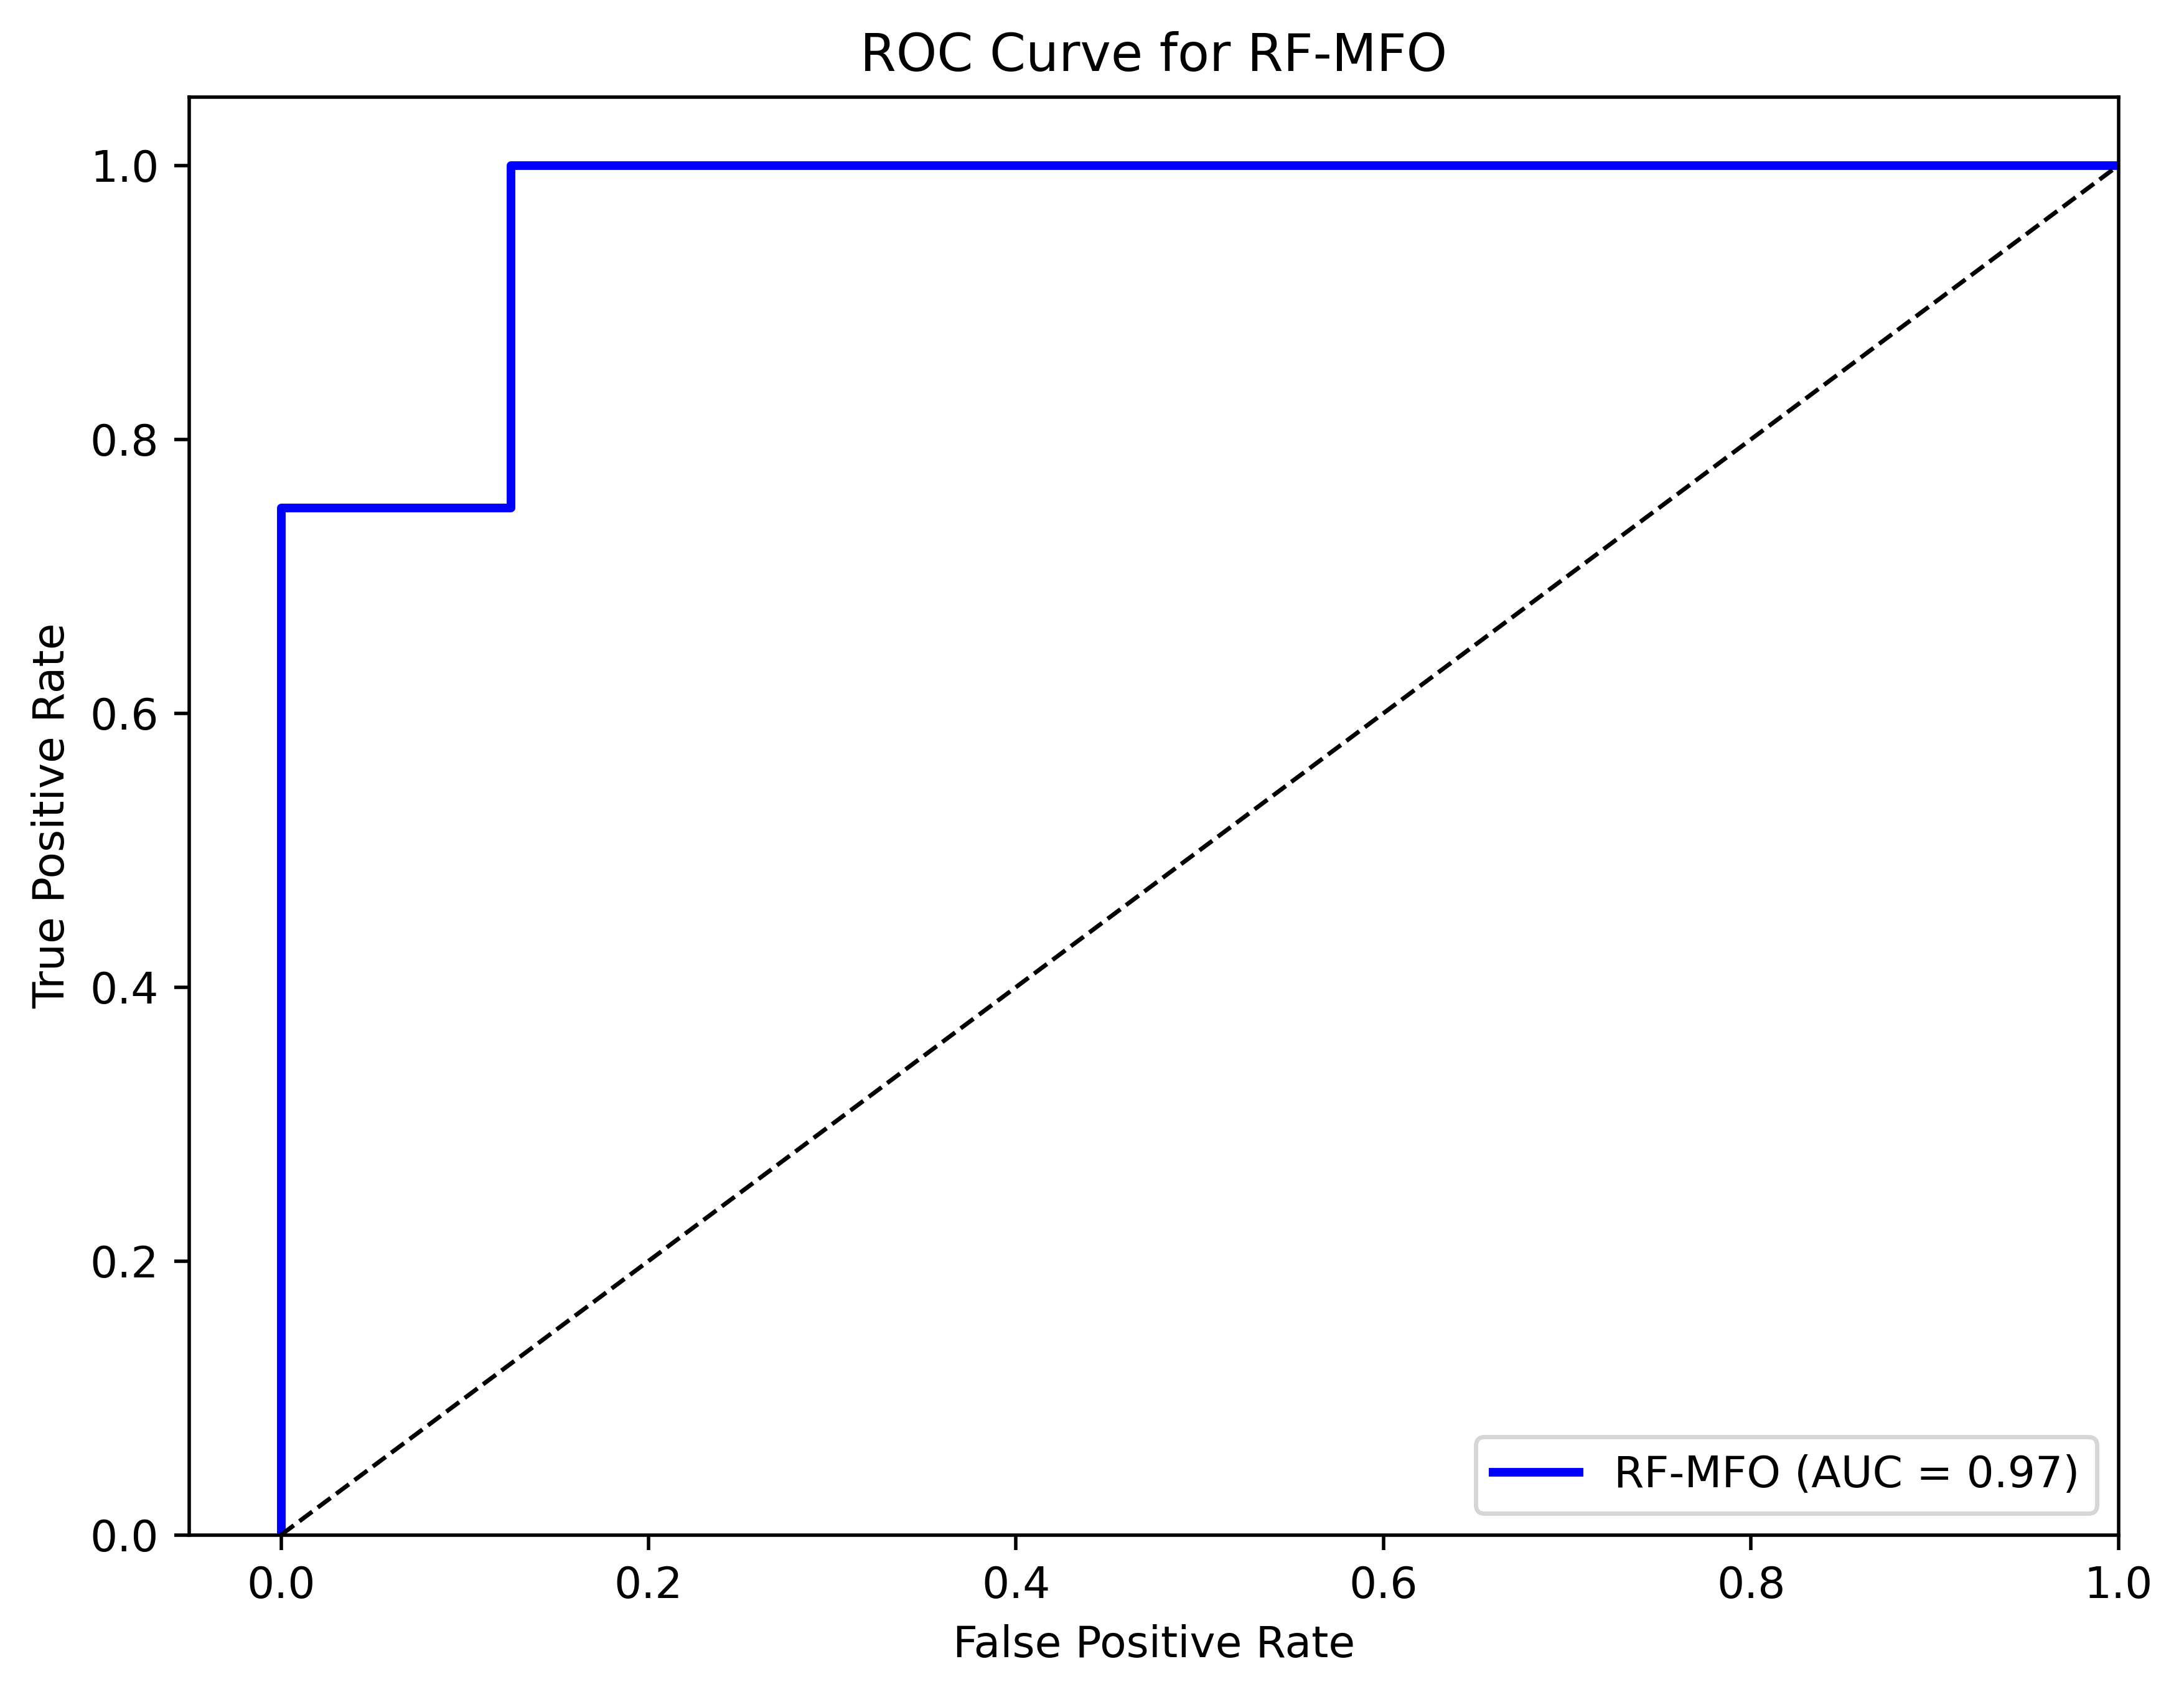

In [ ]:
# prompt: GENERATE THE ROC PLOT FOR ONLY RF-MFO

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming you have y_test and probabilities for RF-MFO
# Example:
# rf_mfo_probs = rf_mfo.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

fpr_rf_mfo, tpr_rf_mfo, thresholds_rf_mfo = roc_curve(y_test > threshold, rf_mfo_test_predictions)
roc_auc_rf_mfo = auc(fpr_rf_mfo, tpr_rf_mfo)

# Plot the ROC curve for RF-MFO
plt.figure(figsize=(8, 6), dpi=500)
plt.plot(fpr_rf_mfo, tpr_rf_mfo, color='blue', lw=2, label=f'RF-MFO (AUC = {roc_auc_rf_mfo:.2f})')
plt.plot([0, 1], [0, 1], color='k', lw=1, linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for RF-MFO')
plt.legend(loc="lower right")
plt.show()

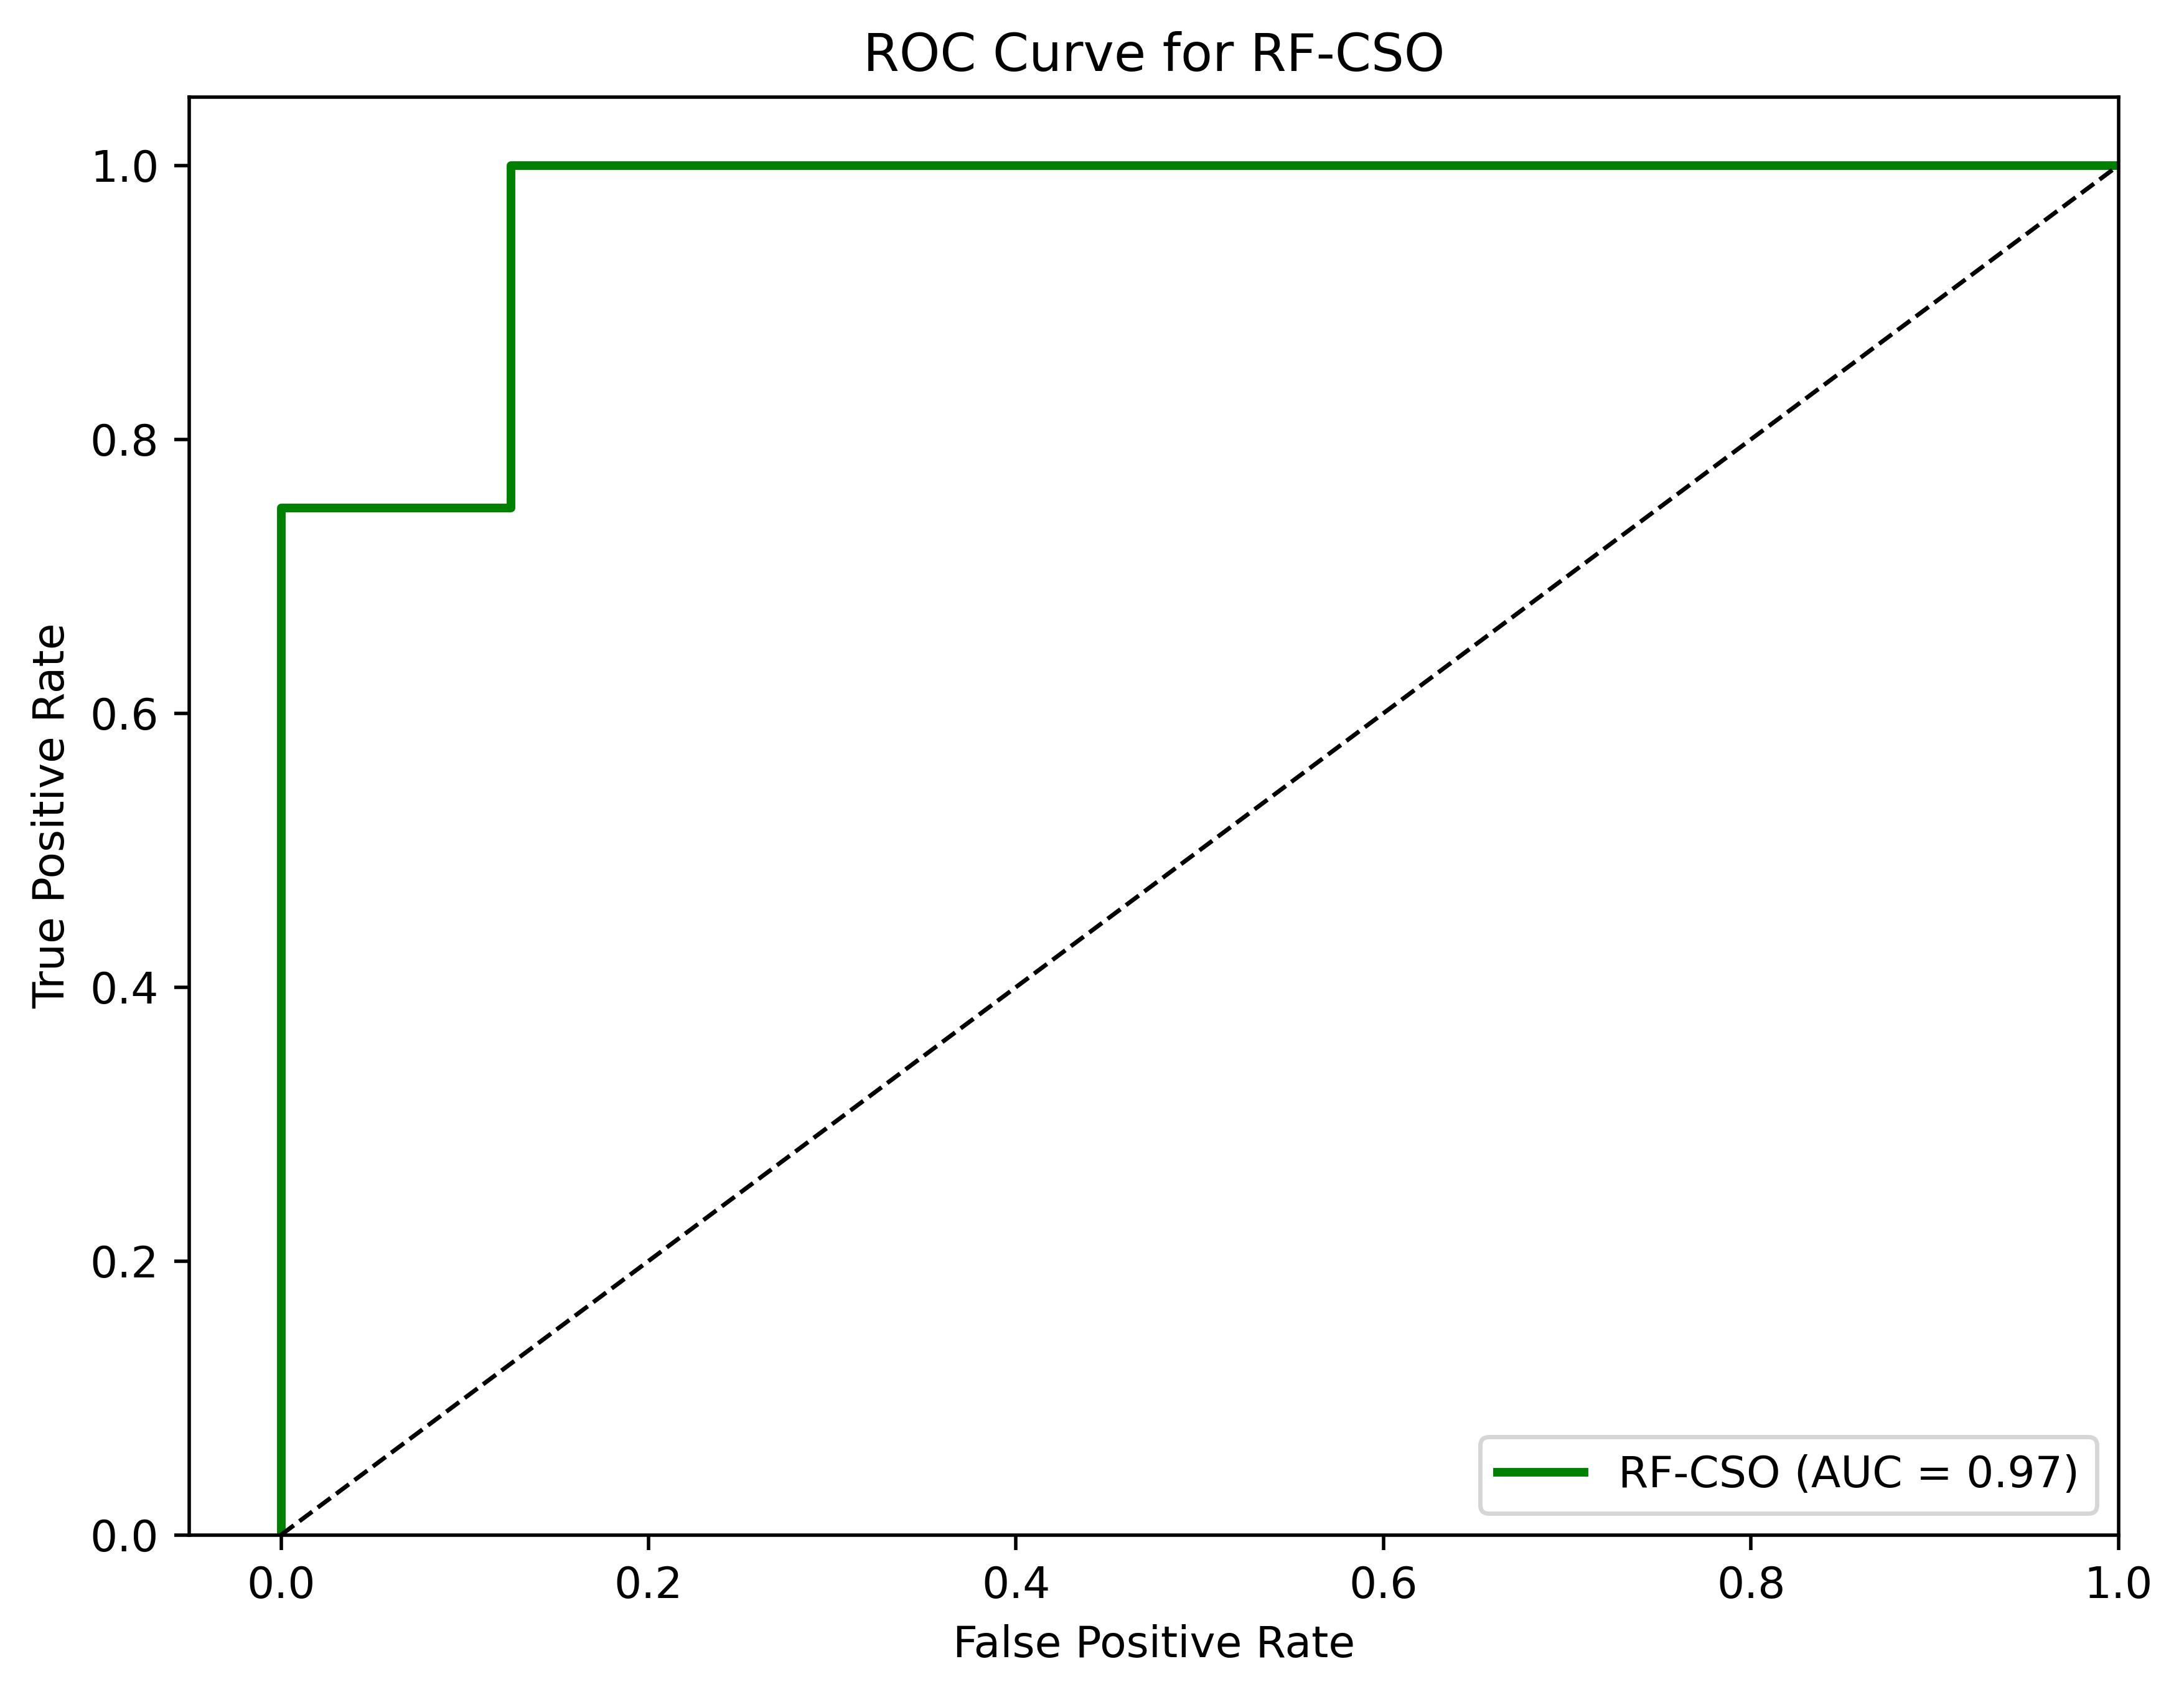

In [ ]:
# prompt: GENERATE THE ROC PLOT FOR ONLY RF-CSO

from sklearn.metrics import roc_curve, auc

# Assuming rf_cso_test_predictions and y_test are defined
fpr_rf_cso, tpr_rf_cso, thresholds_rf_cso = roc_curve(y_test > threshold, rf_cso_test_predictions)
roc_auc_rf_cso = auc(fpr_rf_cso, tpr_rf_cso)

plt.figure(figsize=(8, 6), dpi=500)
plt.plot(fpr_rf_cso, tpr_rf_cso, color='green', lw=2, label=f'RF-CSO (AUC = {roc_auc_rf_cso:.2f})')
plt.plot([0, 1], [0, 1], color='k', lw=1, linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for RF-CSO')
plt.legend(loc="lower right")
plt.show()

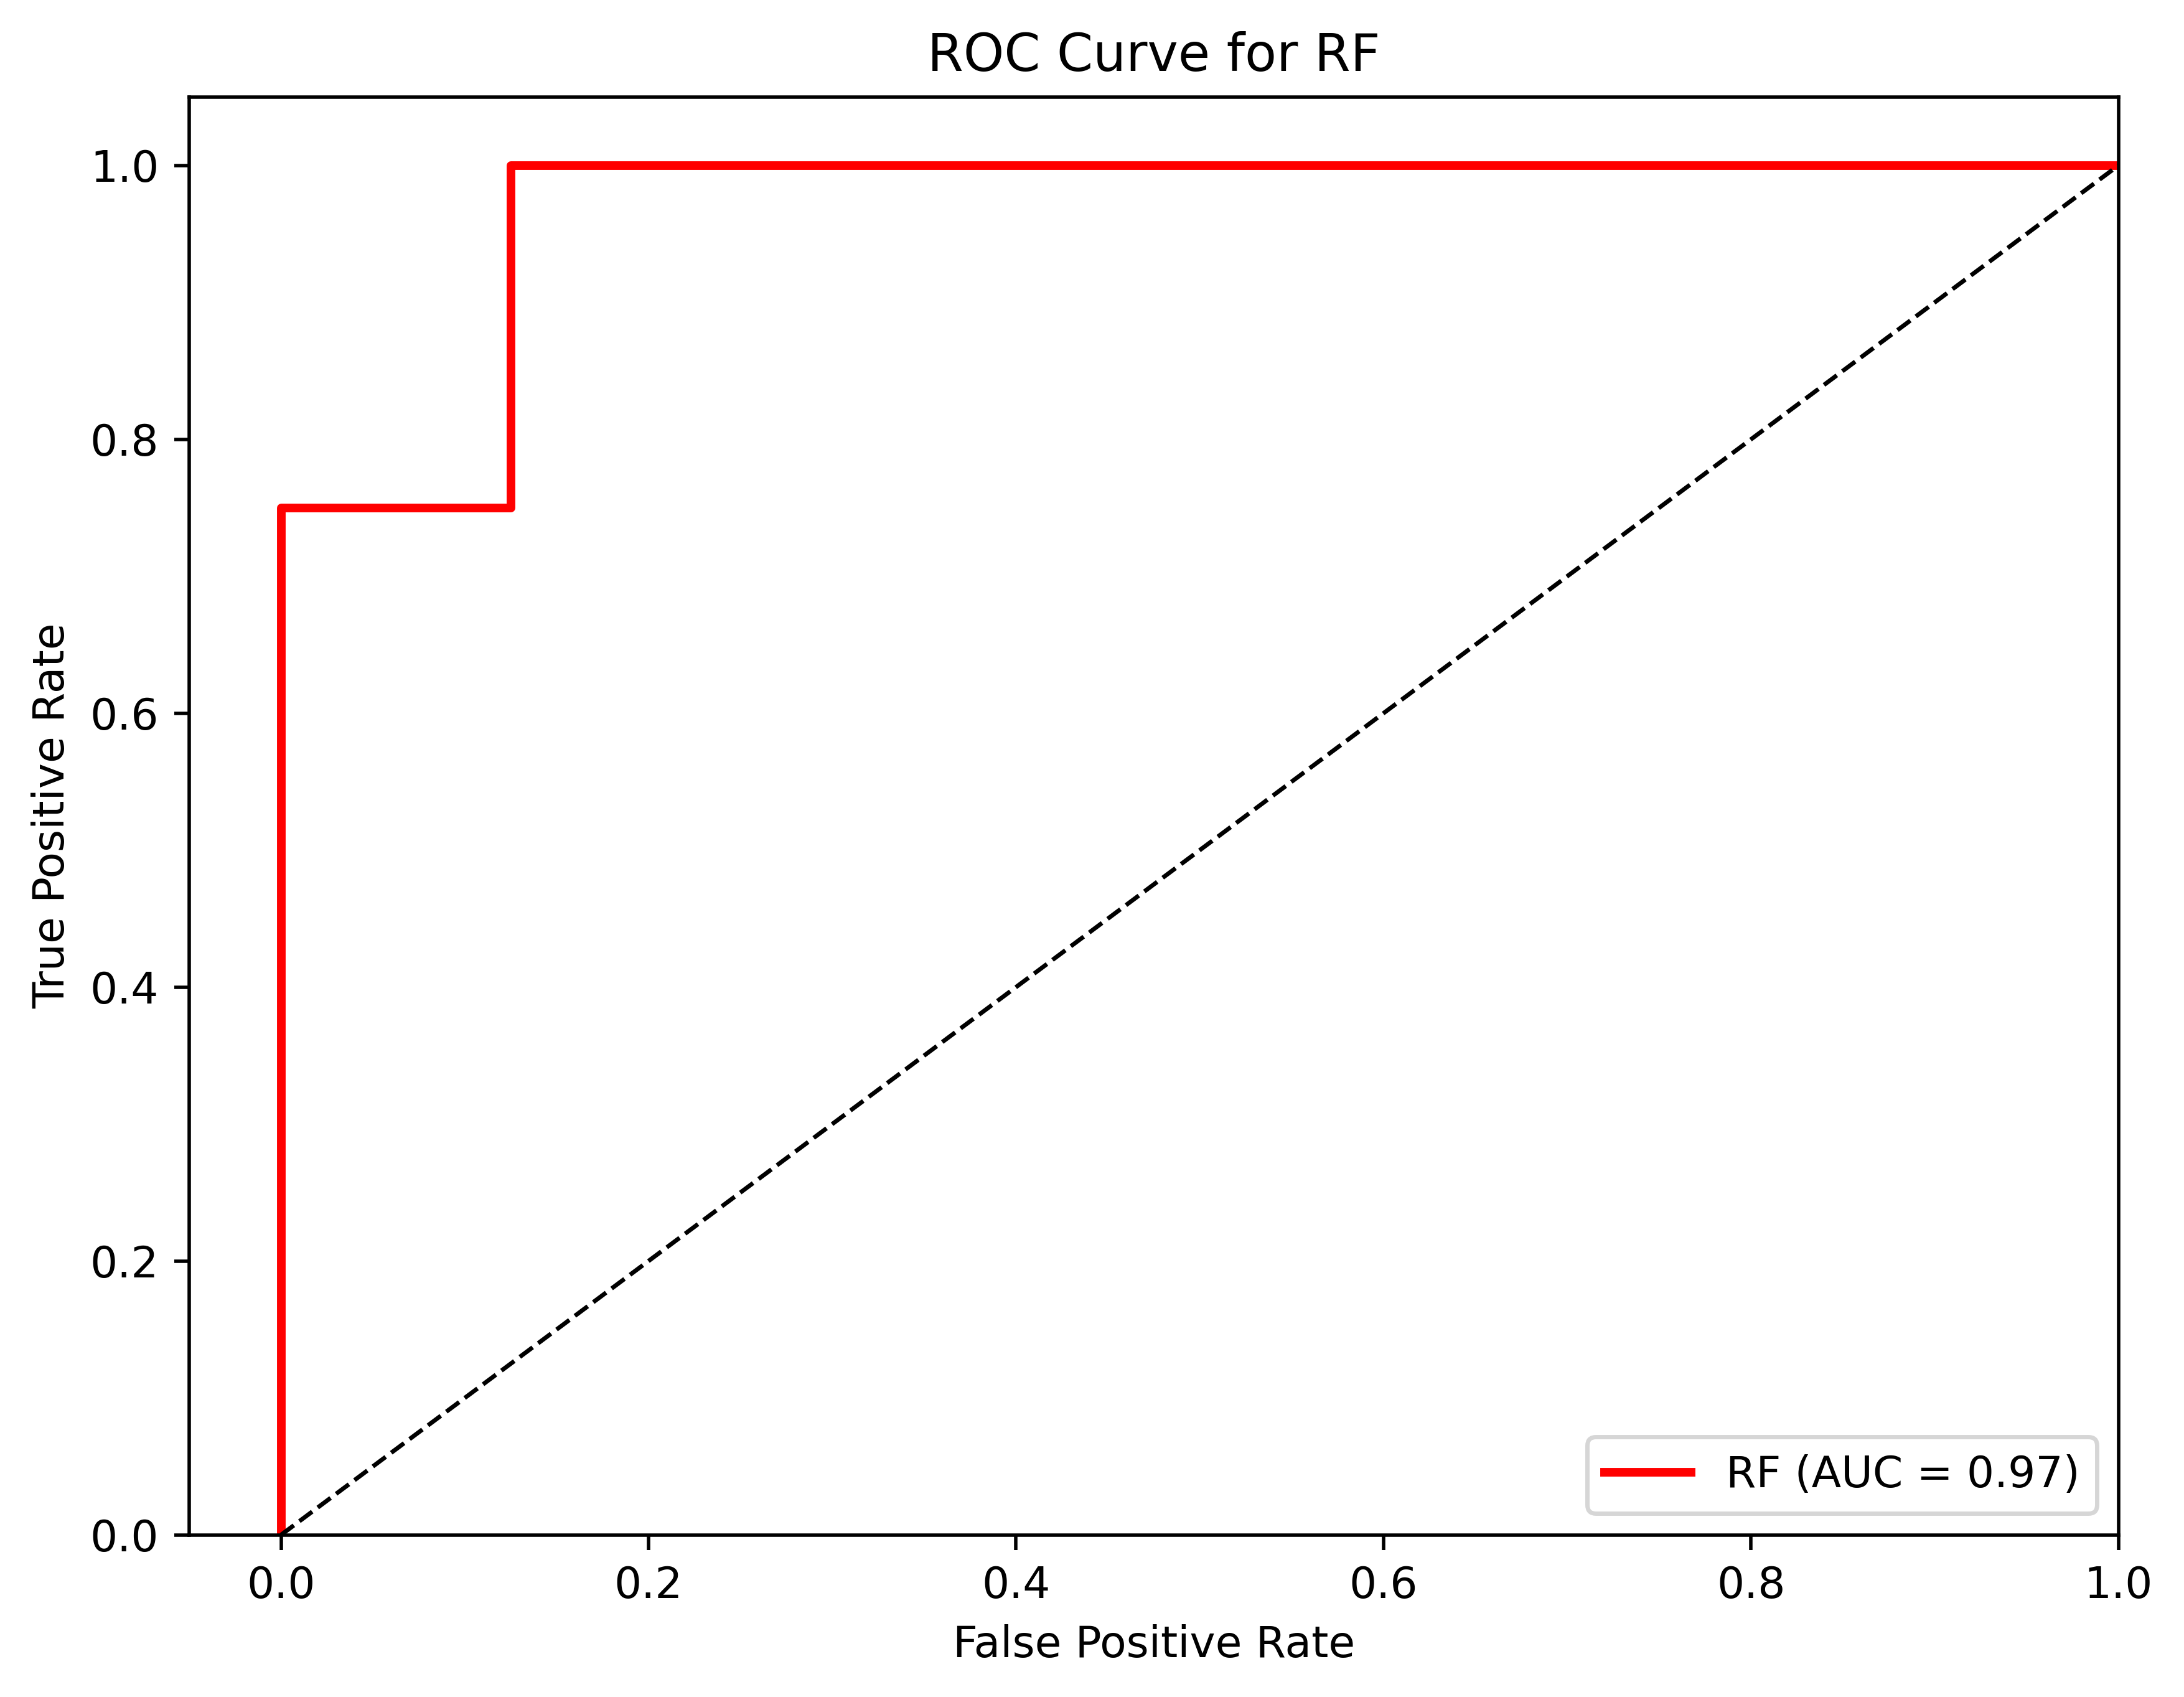

In [ ]:
# prompt: GENERATE THE ROC PLOT FOR ONLY RF

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming you have y_test and rf_test_predictions
# Calculate ROC curve and AUC for RF
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test > threshold, rf_test_predictions)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plot ROC curve for RF
plt.figure(figsize=(8, 6), dpi=500)
plt.plot(fpr_rf, tpr_rf, color='red', lw=2, label=f'RF (AUC = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='k', lw=1, linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for RF')
plt.legend(loc="lower right")
plt.show()

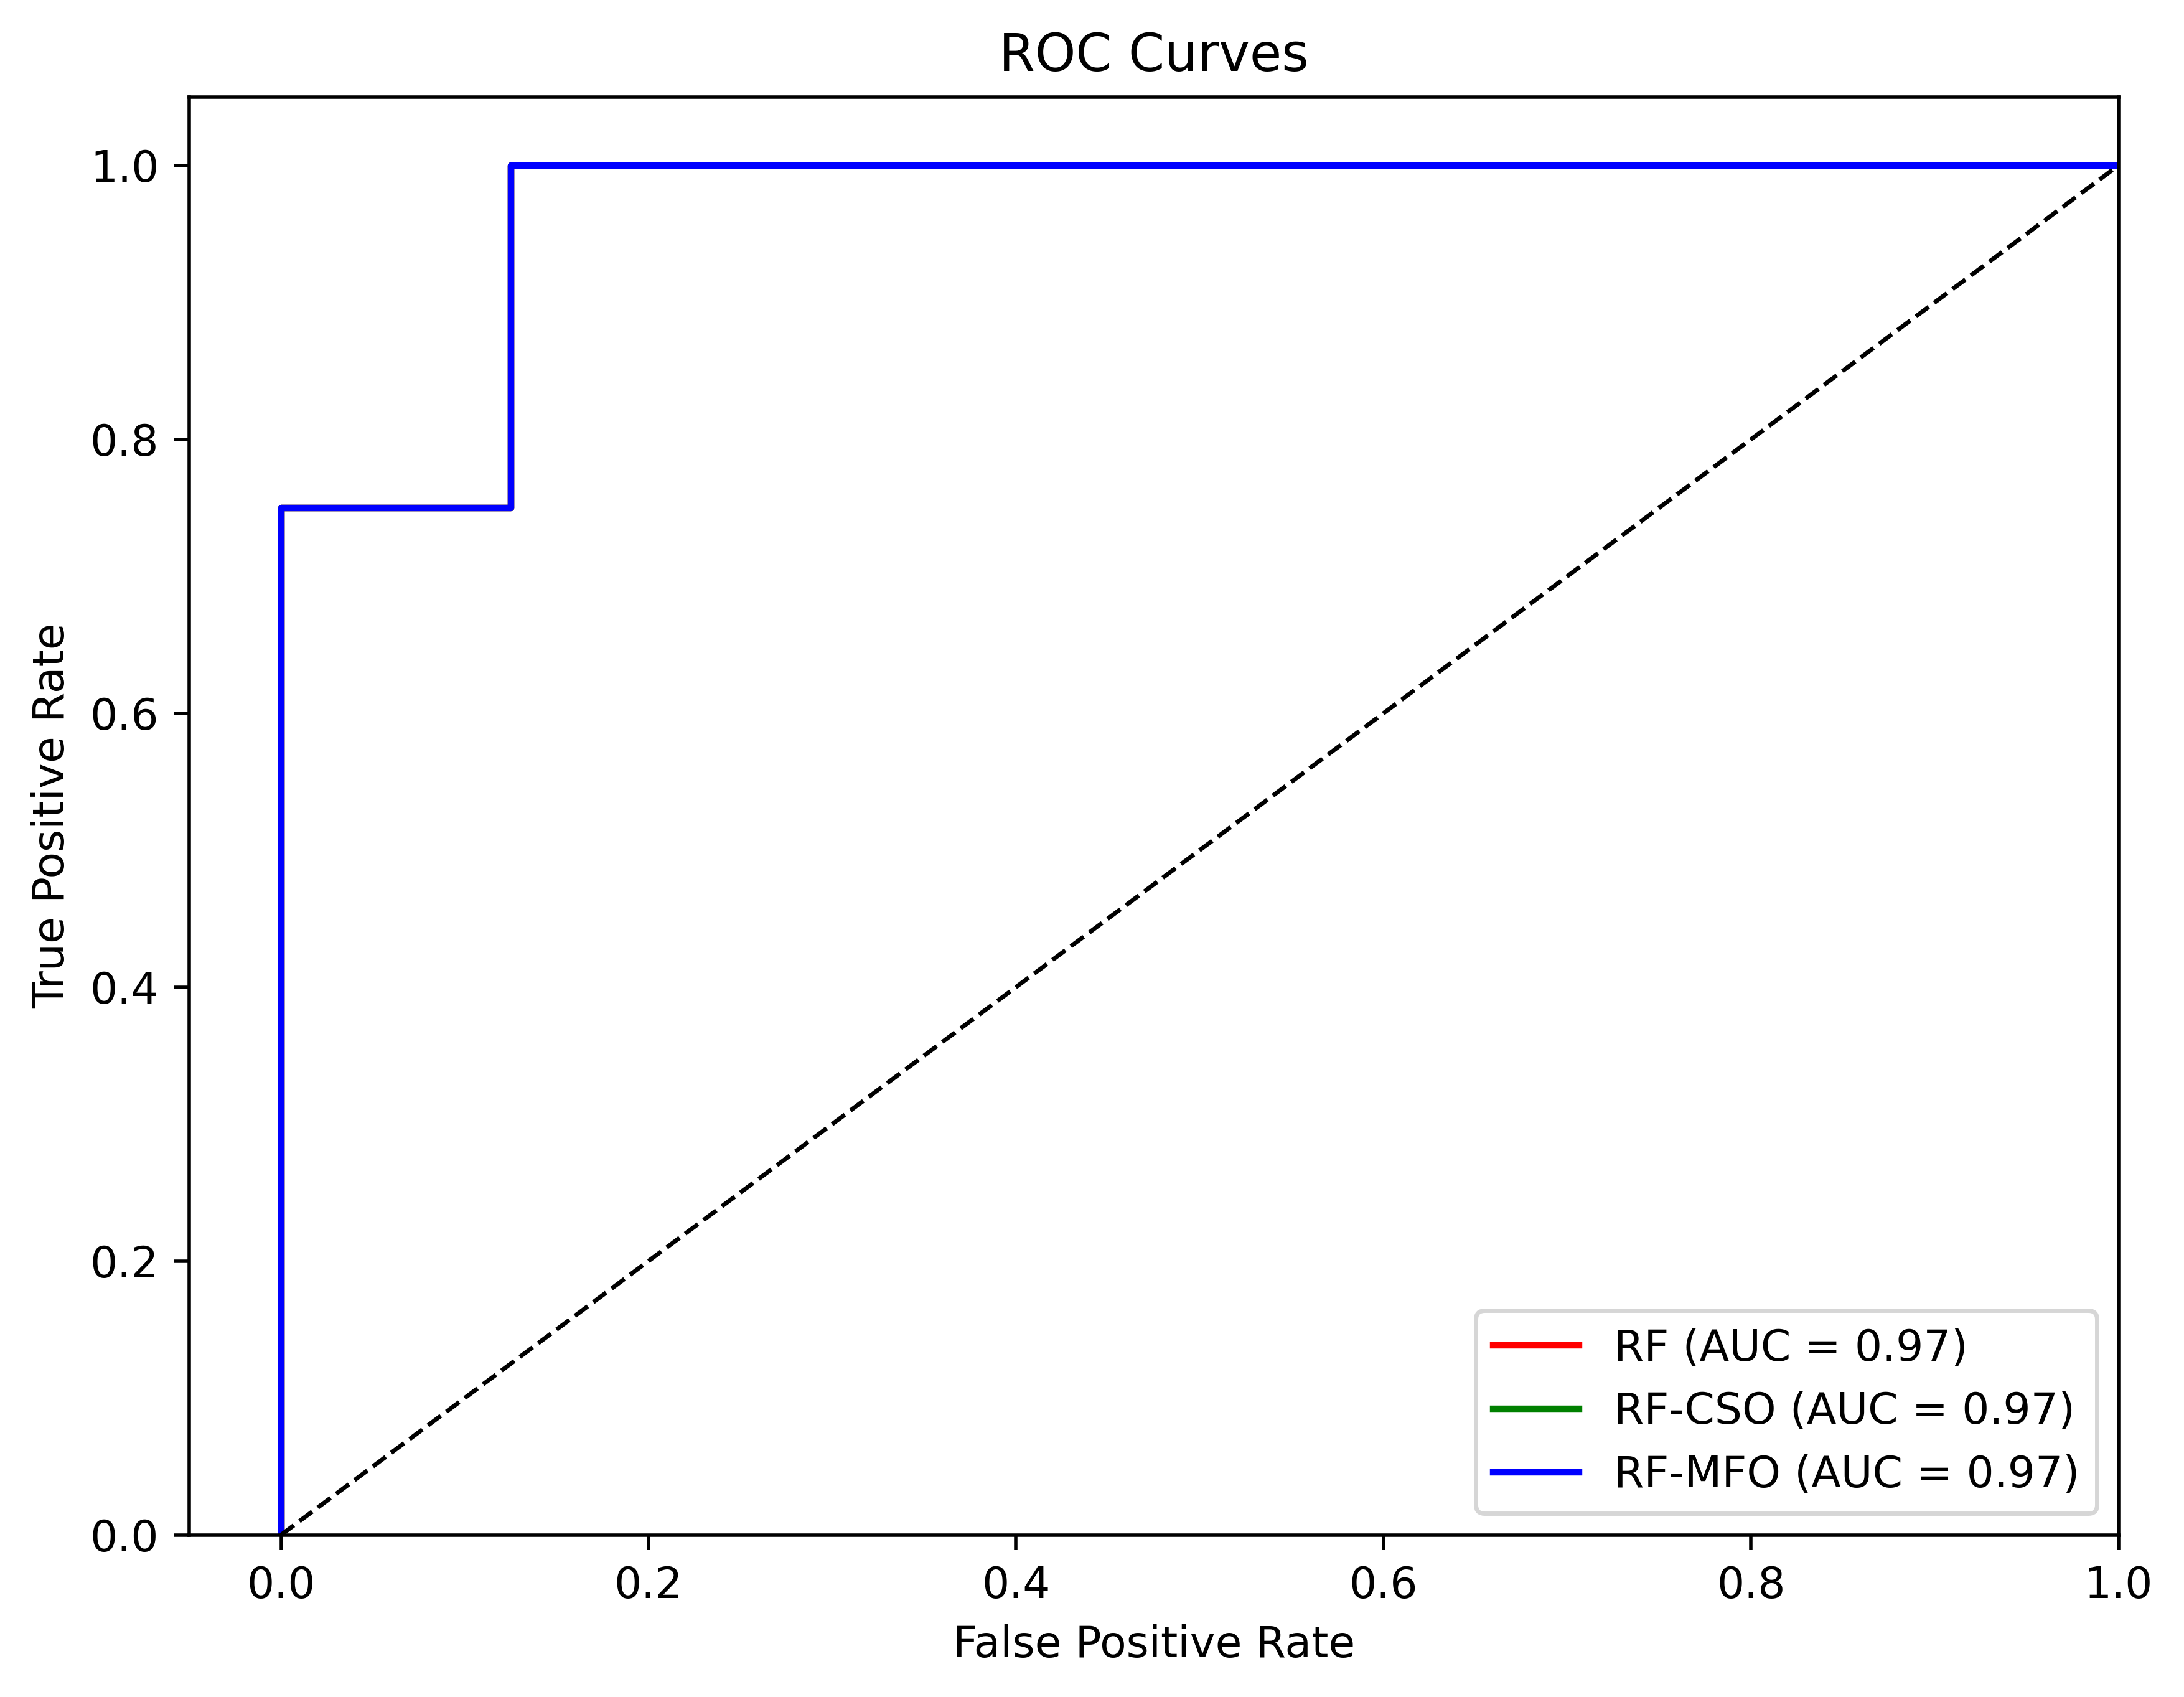

In [ ]:
# prompt: GENERATE THE ROC PLOT FOR THE MODELS

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming rf_test_predictions, rf_cso_test_predictions, and rf_mfo_test_predictions are probabilities
# If not, you might need to use predict_proba

fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test > threshold, rf_test_predictions)
roc_auc_rf = auc(fpr_rf, tpr_rf)

fpr_rf_cso, tpr_rf_cso, thresholds_rf_cso = roc_curve(y_test > threshold, rf_cso_test_predictions)
roc_auc_rf_cso = auc(fpr_rf_cso, tpr_rf_cso)

fpr_rf_mfo, tpr_rf_mfo, thresholds_rf_mfo = roc_curve(y_test > threshold, rf_mfo_test_predictions)
roc_auc_rf_mfo = auc(fpr_rf_mfo, tpr_rf_mfo)

plt.figure(figsize=(8, 6), dpi=500)
plt.plot(fpr_rf, tpr_rf, color='red', label=f'RF (AUC = {roc_auc_rf:.2f})')
plt.plot(fpr_rf_cso,  tpr_rf_cso, color='green', label=f'RF-CSO (AUC = {roc_auc_rf_cso:.2f})')
plt.plot(fpr_rf_mfo,  tpr_rf_mfo, color='blue', label=f'RF-MFO (AUC = {roc_auc_rf_mfo:.2f})')
plt.plot([0, 1], [0, 1], color='k', lw=1, linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")
plt.show()